# Data Loading and Imports

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
import zipfile
import numpy as np
import cv2
import torch
import torch.nn as nn
from torchvision import transforms
import torch.nn.functional as F
from sklearn.metrics import average_precision_score
from tqdm import tqdm
from collections import defaultdict
import math
import matplotlib.pyplot as plt
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode
from torch.utils.tensorboard import SummaryWriter
import random
from PIL import Image

NUM_CLASSES = 7

Mounted at /content/drive


In [ ]:
class FaceDetector:
  def __init__(self):
    self.face_classifier = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
  def run(self):
    from PIL import Image, ImageOps
    filename = self.take_photo()
    print('Saved to {}'.format(filename))
    with Image.open('photo.jpg') as img:
      img = ImageOps.grayscale(img)
      img = np.array(img)
    face = self.face_classifier.detectMultiScale(
      img, scaleFactor=1.1, minNeighbors=5, minSize=(40, 40)
    )
    for (x, y, w, h) in face:
        cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 4)
    plt.figure(figsize=(20,10))
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    return self.extractSquare(face, img)

  def extractSquare(self, face, img):
    print(len(face), face)
    for (x, y, w, h) in face:
      cropped_image = img[y:y + h, x:x + w]
      plt.figure(figsize=(20,10))
      plt.imshow(cropped_image, cmap='gray')
      plt.axis('off')
      break
    return cropped_image

  def take_photo(self, filename='photo.jpg', quality=0.8):
    js = Javascript('''
      async function takePhoto(quality) {
        const div = document.createElement('div');
        const capture = document.createElement('button');
        capture.textContent = 'Capture';
        div.appendChild(capture);

        const video = document.createElement('video');
        video.style.display = 'block';
        const stream = await navigator.mediaDevices.getUserMedia({video: true});

        document.body.appendChild(div);
        div.appendChild(video);
        video.srcObject = stream;
        await video.play();

        google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

        await new Promise((resolve) => capture.onclick = resolve);

        const canvas = document.createElement('canvas');
        canvas.width = video.videoWidth;
        canvas.height = video.videoHeight;
        canvas.getContext('2d').drawImage(video, 0, 0);
        stream.getVideoTracks()[0].stop();
        div.remove();
        return canvas.toDataURL('image/jpeg', quality);
      }
      ''')
    display(js)
    data = eval_js('takePhoto({})'.format(quality))
    binary = b64decode(data.split(',')[1])

    with open(filename, 'wb') as f:
      f.write(binary)
    return filename


In [ ]:
def load_data():
  tr_images, tr_labels = [], []
  val_images, val_labels = [], []
  ptr = 0
  mapper, revMapper = {}, {}
  LIMIT = math.inf
  counter = defaultdict(int)


  with zipfile.ZipFile("/content/drive/MyDrive/682Final/data.zip", "r") as zip_ref:
    for filePath in zip_ref.namelist():
      try:
        emotion = filePath.split("/")[2]
        if emotion == 'train' or emotion == 'validation':
          continue
        if emotion not in revMapper:
          mapper[ptr] = emotion
          revMapper[emotion] = ptr
          ptr += 1

        if counter[emotion] >= LIMIT:
          continue

        counter[emotion] += 1


        image_raw = zip_ref.read(filePath)
        image = np.array(cv2.imdecode(np.frombuffer(image_raw, dtype=np.uint8), cv2.IMREAD_GRAYSCALE))

        if "train" in filePath:
          tr_images.append(image)
          tr_labels.append(revMapper[emotion])
        else:
          val_images.append(image)
          val_labels.append(revMapper[emotion])
      except:
        pass

  return np.array(tr_images), np.array(tr_labels), np.array(val_images), np.array(val_labels), mapper, revMapper

tr_img, tr_lab, val_img, val_lab, mapper, revMapper = load_data()
tr_img.shape, tr_lab.shape

((28821, 48, 48), (28821,))

In [ ]:
def rand_reorder(img, lab):
  randIdx = np.random.permutation(len(img))
  img = img[randIdx]
  lab = lab[randIdx]
  return img, lab

In [ ]:
tr_img, tr_lab = rand_reorder(tr_img, tr_lab)
val_img, val_lab = rand_reorder(val_img, val_lab)

happy


array([[254, 248, 247, ..., 131, 136, 172],
       [249, 249, 249, ..., 121, 134, 163],
       [250, 250, 246, ..., 108, 142, 137],
       ...,
       [251, 247, 251, ...,  32,  74, 166],
       [251, 246, 248, ...,  63,  82, 184],
       [249, 252, 250, ..., 125, 162,  56]], dtype=uint8)
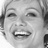

In [ ]:
print(mapper[tr_lab[0]])
tr_img[0]

In [ ]:
from sklearn.model_selection import train_test_split

tr_img, X_test, tr_lab, y_test = train_test_split(tr_img, tr_lab, test_size=0.2, random_state=42)


In [ ]:
transform1 = transforms.Compose([
    transforms.RandomRotation((0, 25))
])

transform2 = transforms.Compose([
    transforms.GaussianBlur(3)
])

transform3 = transforms.Compose([
    transforms.RandomRotation((335, 360))
])

transform4 = transforms.Compose([
    transforms.GaussianBlur(5)
])


transformed_images = []
transformed_labs = []

for i in range(int(tr_img.shape[0] * 0.1)):
    ridx = random.randint(0, tr_img.shape[0] - 1)
    transformed_images.append(transform1(Image.fromarray(tr_img[ridx])))
    transformed_labs.append(tr_lab[ridx])
for i in range(int(tr_img.shape[0] * 0.04)):
    ridx = random.randint(0, tr_img.shape[0] - 1)
    transformed_images.append(transform3(Image.fromarray(tr_img[ridx])))
    transformed_labs.append(tr_lab[ridx])

for i in range(int(tr_img.shape[0] * 0.1)):
    ridx = random.randint(0, tr_img.shape[0] - 1)
    transformed_images.append(transform2(Image.fromarray(tr_img[ridx])))
    transformed_labs.append(tr_lab[ridx])

for i in range(int(tr_img.shape[0] * 0.04)):
    ridx = random.randint(0, tr_img.shape[0] - 1)
    transformed_images.append(transform4(Image.fromarray(tr_img[ridx])))
    transformed_labs.append(tr_lab[ridx])


for i in range(int(tr_img.shape[0] * 0.2)):
    ridx = random.randint(0, tr_img.shape[0] - 1)
    transformed_images.append(np.fliplr(tr_img[ridx]))
    transformed_labs.append(tr_lab[ridx])

tr_img = np.concatenate((tr_img, transformed_images))
tr_lab = np.concatenate((tr_lab, transformed_labs))


## Flipping horizontally

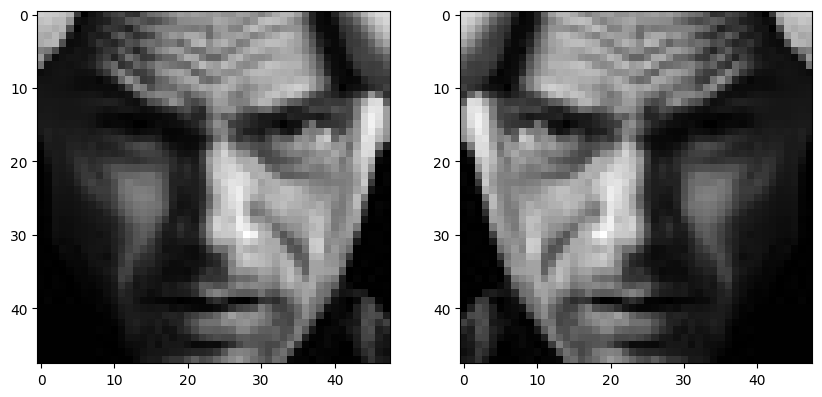

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(tr_img[0], cmap = 'gray')
axes[1].imshow(np.fliplr(tr_img[0]), cmap = 'gray')

plt.show()

## Rotation

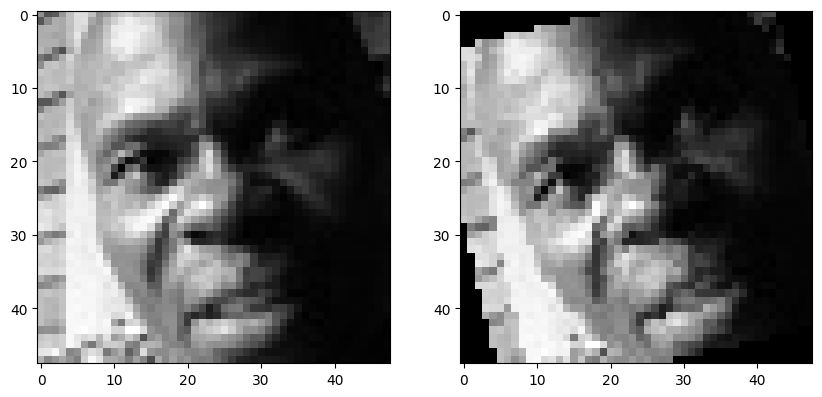

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(tr_img[55], cmap = 'gray')
axes[1].imshow(transform1(Image.fromarray(tr_img[55])), cmap = 'gray')

plt.show()

## Blurring

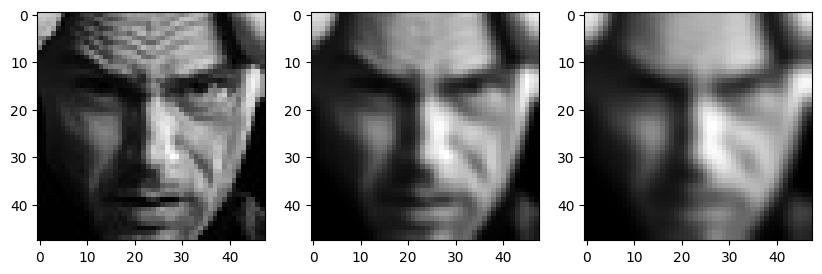

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(10, 5))
indx = 0
axes[0].imshow(tr_img[indx], cmap = 'gray')
axes[1].imshow(transform2(Image.fromarray(tr_img[indx])), cmap = 'gray')
axes[2].imshow(transform4(Image.fromarray(tr_img[indx])), cmap = 'gray')

plt.show()

# Loaders

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
BATCH_SIZE = 256
train_dataset = torch.utils.data.TensorDataset(torch.Tensor(tr_img), torch.LongTensor(tr_lab))
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [ ]:
val_dataset = torch.utils.data.TensorDataset(torch.Tensor(val_img), torch.LongTensor(val_lab))
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [ ]:
def train_classifier(train_loader, classifier, criterion, optimizer):
    classifier.train()
    loss_ = 0.0
    losses = []

    for i, (images, labels) in enumerate(tqdm(train_loader)):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        logits = classifier(images)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        losses.append(loss)

    return torch.stack(losses).mean().item()

In [ ]:
def test_classifier(test_loader, classifier):
    classifier.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = classifier(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print('Accuracy of the network on the test images: %d %%' % (
        accuracy))
    return accuracy


In [ ]:
class Classifier(nn.Module):
    def __init__(self, n_labels):
        super(Classifier, self).__init__()



        self.conv1 = nn.Conv2d(1, 128, 5)
        self.conv2 = nn.Conv2d(128, 64, 3)
        self.conv3 = nn.Conv2d(64, 32, 3)
        # self.conv4 = nn.Conv2d(32, 16, 3)
        self.dropout = nn.Dropout(0.3)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(512, 64)
        self.fc2 = nn.Linear(64, NUM_CLASSES)


    def forward(self, x):
        shape = []
        for s in x.size():
          shape.append(s)
        shape.insert(1, 1)
        x = x.view(shape)
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        # print('l0', x.size())

        x = x.view(-1, self.flatten(x))
        # print('l1', x.size())

        x = F.relu(self.fc1(x))
        # x = self.dropout(x)
        # print('l2', x.size())
        # x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

    def flatten(self, x):
        res = 1
        for s in x.size()[1:]:
            res *= s
        return res

In [ ]:
classifier = Classifier(NUM_CLASSES).to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(classifier.parameters())

Starting epoch number 1


100%|██████████| 134/134 [00:06<00:00, 22.28it/s]


Loss for Training on Epoch 1 is 1.834102749824524
Starting epoch number 2


100%|██████████| 134/134 [00:04<00:00, 32.61it/s]


Loss for Training on Epoch 2 is 1.5524975061416626
Starting epoch number 3


100%|██████████| 134/134 [00:04<00:00, 32.55it/s]


Loss for Training on Epoch 3 is 1.4721152782440186


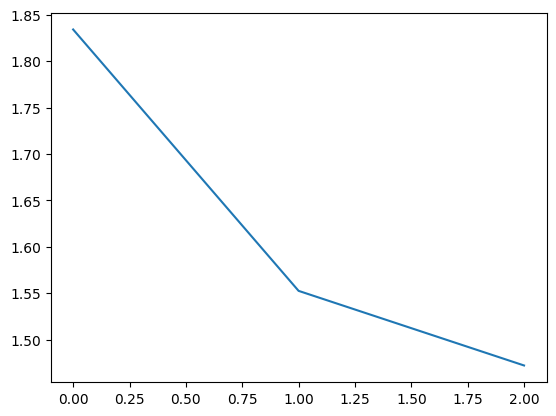

Starting epoch number 4


100%|██████████| 134/134 [00:04<00:00, 32.31it/s]


Loss for Training on Epoch 4 is 1.406333088874817
Starting epoch number 5


100%|██████████| 134/134 [00:04<00:00, 32.52it/s]


Loss for Training on Epoch 5 is 1.3463504314422607
Starting epoch number 6


100%|██████████| 134/134 [00:04<00:00, 32.44it/s]


Loss for Training on Epoch 6 is 1.2994277477264404


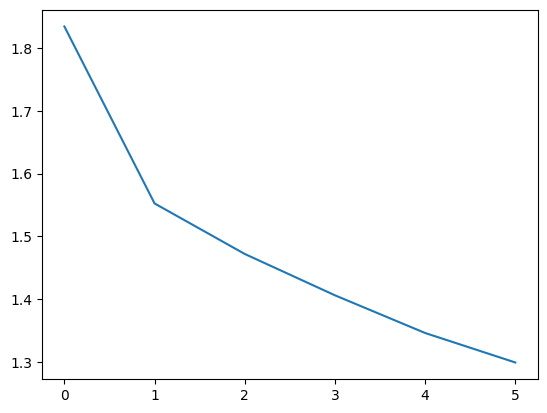

Starting epoch number 7


100%|██████████| 134/134 [00:04<00:00, 32.20it/s]


Loss for Training on Epoch 7 is 1.2521162033081055
Starting epoch number 8


100%|██████████| 134/134 [00:04<00:00, 32.38it/s]


Loss for Training on Epoch 8 is 1.2134917974472046
Starting epoch number 9


100%|██████████| 134/134 [00:04<00:00, 32.35it/s]


Loss for Training on Epoch 9 is 1.1777782440185547


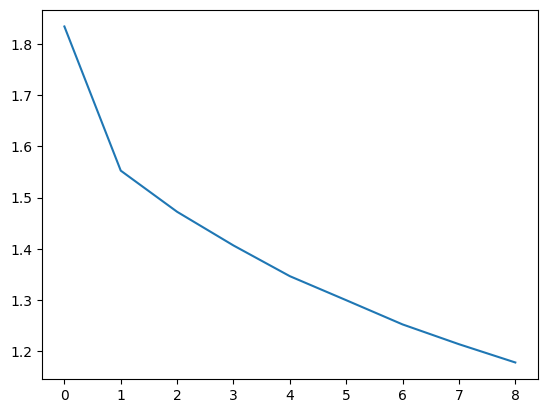

Starting epoch number 10


100%|██████████| 134/134 [00:04<00:00, 29.09it/s]


Loss for Training on Epoch 10 is 1.1407896280288696
Accuracy of the network on the test images: 52 %
Accuarcy on validation set: 52.66062836116615


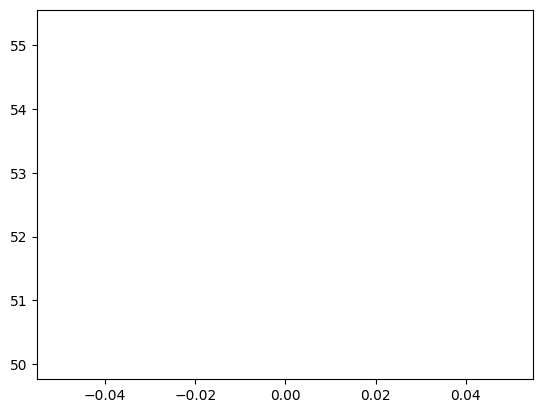

Starting epoch number 11


100%|██████████| 134/134 [00:04<00:00, 32.22it/s]


Loss for Training on Epoch 11 is 1.1118192672729492
Starting epoch number 12


100%|██████████| 134/134 [00:04<00:00, 32.18it/s]


Loss for Training on Epoch 12 is 1.079628586769104


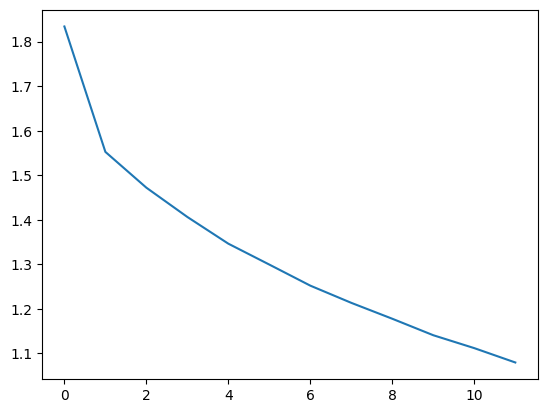

Starting epoch number 13


100%|██████████| 134/134 [00:04<00:00, 32.01it/s]


Loss for Training on Epoch 13 is 1.045711636543274
Starting epoch number 14


100%|██████████| 134/134 [00:04<00:00, 32.07it/s]


Loss for Training on Epoch 14 is 1.018376350402832
Starting epoch number 15


100%|██████████| 134/134 [00:04<00:00, 32.00it/s]


Loss for Training on Epoch 15 is 0.9871261119842529


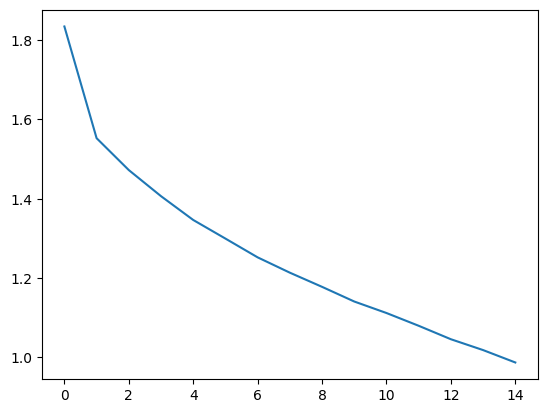

Starting epoch number 16


100%|██████████| 134/134 [00:04<00:00, 31.77it/s]


Loss for Training on Epoch 16 is 0.9561100006103516
Starting epoch number 17


100%|██████████| 134/134 [00:04<00:00, 31.86it/s]


Loss for Training on Epoch 17 is 0.9345241785049438
Starting epoch number 18


100%|██████████| 134/134 [00:04<00:00, 31.81it/s]


Loss for Training on Epoch 18 is 0.9054186940193176


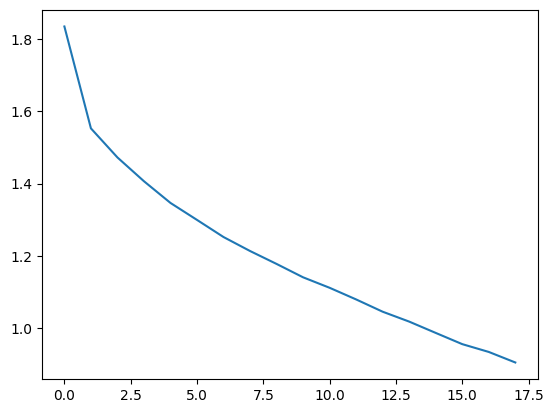

Starting epoch number 19


100%|██████████| 134/134 [00:04<00:00, 31.58it/s]


Loss for Training on Epoch 19 is 0.8875765204429626
Starting epoch number 20


100%|██████████| 134/134 [00:04<00:00, 29.69it/s]


Loss for Training on Epoch 20 is 0.8592369556427002
Accuracy of the network on the test images: 52 %
Accuarcy on validation set: 52.06623266345882


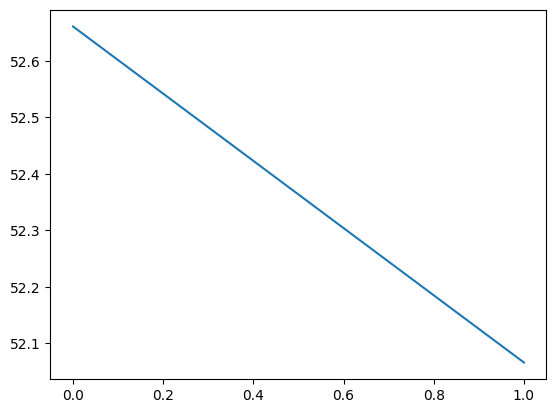

Starting epoch number 21


100%|██████████| 134/134 [00:04<00:00, 31.56it/s]


Loss for Training on Epoch 21 is 0.8352525234222412


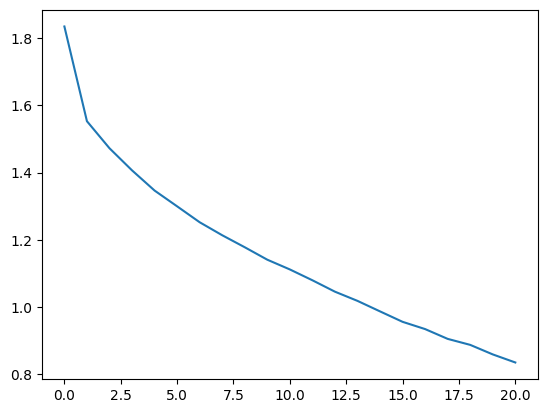

Starting epoch number 22


100%|██████████| 134/134 [00:04<00:00, 31.35it/s]


Loss for Training on Epoch 22 is 0.8137219548225403
Starting epoch number 23


100%|██████████| 134/134 [00:04<00:00, 31.38it/s]


Loss for Training on Epoch 23 is 0.7935504913330078
Starting epoch number 24


100%|██████████| 134/134 [00:04<00:00, 31.35it/s]


Loss for Training on Epoch 24 is 0.7781774997711182


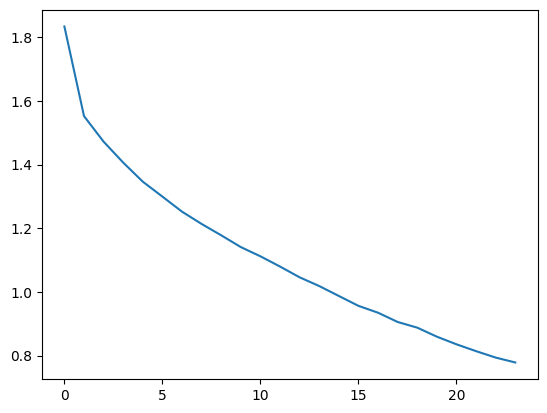

Starting epoch number 25


100%|██████████| 134/134 [00:04<00:00, 31.15it/s]


Loss for Training on Epoch 25 is 0.7484469413757324
Starting epoch number 26


100%|██████████| 134/134 [00:04<00:00, 31.26it/s]


Loss for Training on Epoch 26 is 0.7389143109321594
Starting epoch number 27


100%|██████████| 134/134 [00:04<00:00, 31.31it/s]


Loss for Training on Epoch 27 is 0.713854968547821


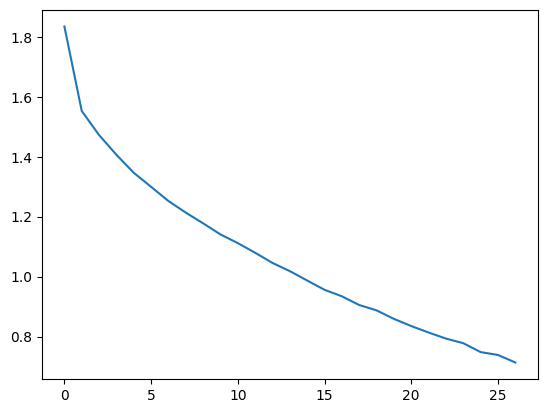

Starting epoch number 28


100%|██████████| 134/134 [00:04<00:00, 31.31it/s]


Loss for Training on Epoch 28 is 0.6882238388061523
Starting epoch number 29


100%|██████████| 134/134 [00:04<00:00, 31.42it/s]


Loss for Training on Epoch 29 is 0.677743673324585
Starting epoch number 30


100%|██████████| 134/134 [00:04<00:00, 31.51it/s]


Loss for Training on Epoch 30 is 0.6607096791267395


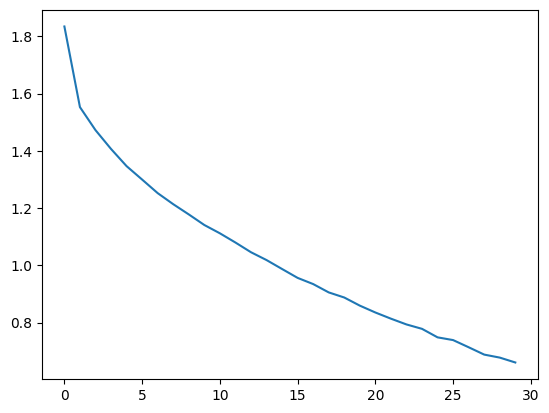

Accuracy of the network on the test images: 50 %
Accuarcy on validation set: 50.90574582507784


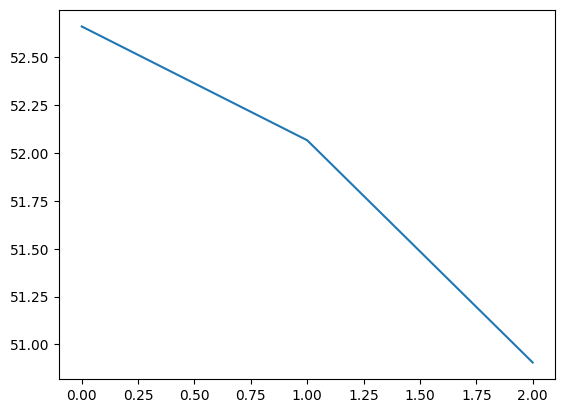

Starting epoch number 31


100%|██████████| 134/134 [00:04<00:00, 31.45it/s]


Loss for Training on Epoch 31 is 0.6436777710914612
Starting epoch number 32


100%|██████████| 134/134 [00:04<00:00, 31.57it/s]


Loss for Training on Epoch 32 is 0.6303011775016785
Starting epoch number 33


100%|██████████| 134/134 [00:04<00:00, 31.60it/s]


Loss for Training on Epoch 33 is 0.6208311319351196


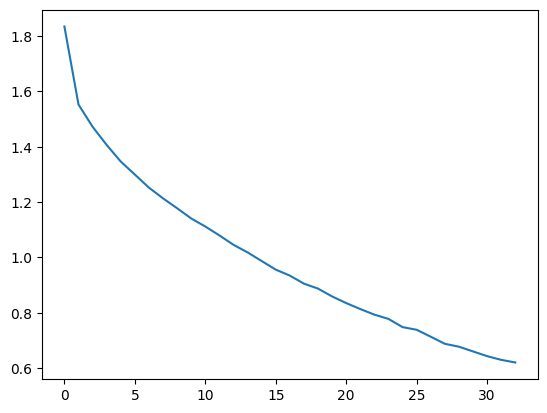

Starting epoch number 34


100%|██████████| 134/134 [00:04<00:00, 31.51it/s]


Loss for Training on Epoch 34 is 0.603683352470398
Starting epoch number 35


100%|██████████| 134/134 [00:04<00:00, 31.61it/s]


Loss for Training on Epoch 35 is 0.5901973247528076
Starting epoch number 36


100%|██████████| 134/134 [00:04<00:00, 31.68it/s]


Loss for Training on Epoch 36 is 0.5883576273918152


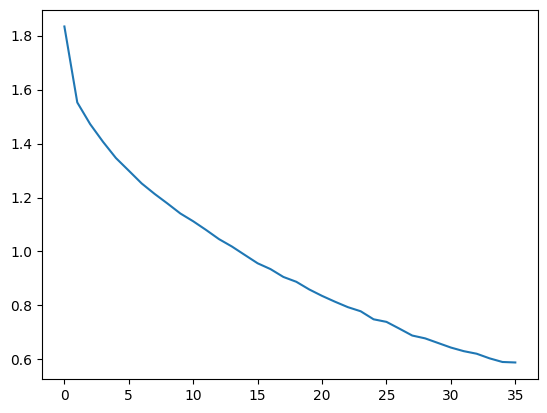

Starting epoch number 37


100%|██████████| 134/134 [00:04<00:00, 31.55it/s]


Loss for Training on Epoch 37 is 0.5614099502563477
Starting epoch number 38


100%|██████████| 134/134 [00:04<00:00, 31.61it/s]


Loss for Training on Epoch 38 is 0.5384314060211182
Starting epoch number 39


100%|██████████| 134/134 [00:04<00:00, 29.53it/s]


Loss for Training on Epoch 39 is 0.5446630120277405


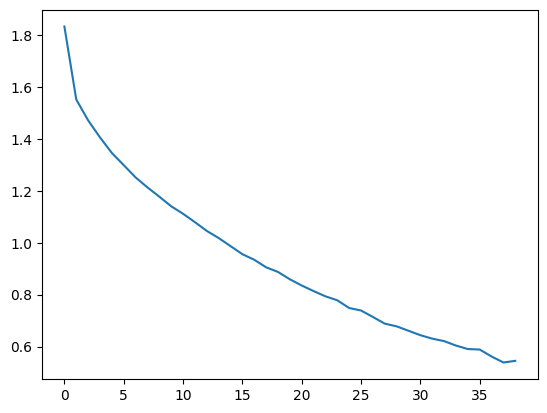

Starting epoch number 40


100%|██████████| 134/134 [00:04<00:00, 31.53it/s]


Loss for Training on Epoch 40 is 0.5273221135139465
Accuracy of the network on the test images: 50 %
Accuarcy on validation set: 50.12737050665157


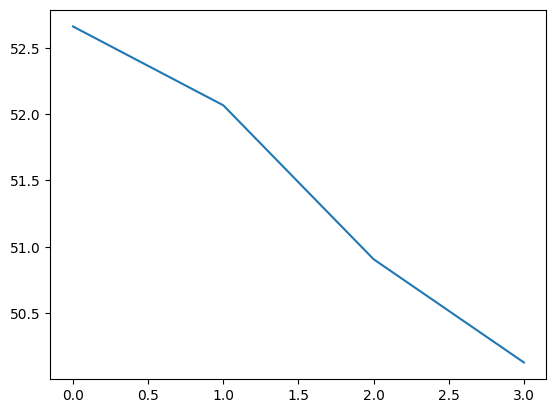

Starting epoch number 41


100%|██████████| 134/134 [00:04<00:00, 31.45it/s]


Loss for Training on Epoch 41 is 0.5120972394943237
Starting epoch number 42


100%|██████████| 134/134 [00:04<00:00, 31.60it/s]


Loss for Training on Epoch 42 is 0.502504289150238


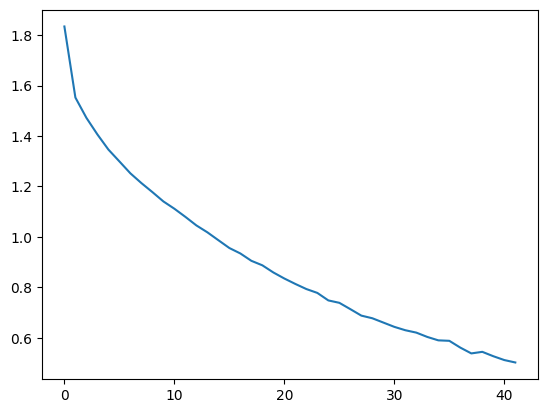

Starting epoch number 43


100%|██████████| 134/134 [00:04<00:00, 31.46it/s]


Loss for Training on Epoch 43 is 0.5025753974914551
Starting epoch number 44


100%|██████████| 134/134 [00:04<00:00, 31.45it/s]


Loss for Training on Epoch 44 is 0.4801698327064514
Starting epoch number 45


100%|██████████| 134/134 [00:04<00:00, 31.48it/s]


Loss for Training on Epoch 45 is 0.46624964475631714


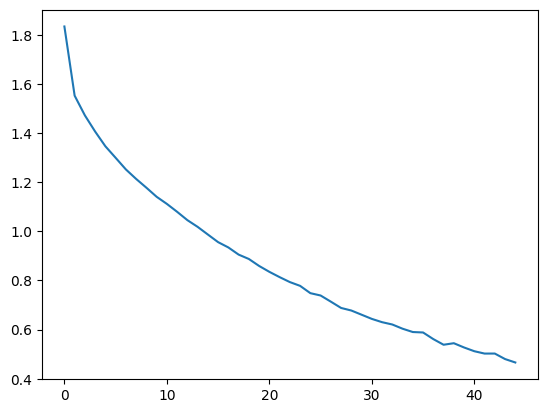

Starting epoch number 46


100%|██████████| 134/134 [00:04<00:00, 31.44it/s]


Loss for Training on Epoch 46 is 0.49328845739364624
Starting epoch number 47


100%|██████████| 134/134 [00:04<00:00, 31.40it/s]


Loss for Training on Epoch 47 is 0.4745185673236847
Starting epoch number 48


100%|██████████| 134/134 [00:04<00:00, 31.55it/s]


Loss for Training on Epoch 48 is 0.45336154103279114


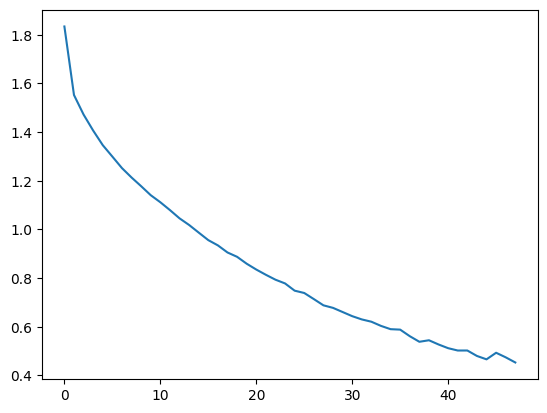

Starting epoch number 49


100%|██████████| 134/134 [00:04<00:00, 31.49it/s]


Loss for Training on Epoch 49 is 0.45179831981658936
Starting epoch number 50


100%|██████████| 134/134 [00:04<00:00, 31.38it/s]


Loss for Training on Epoch 50 is 0.43885841965675354
Accuracy of the network on the test images: 49 %
Accuarcy on validation set: 49.98584772148316


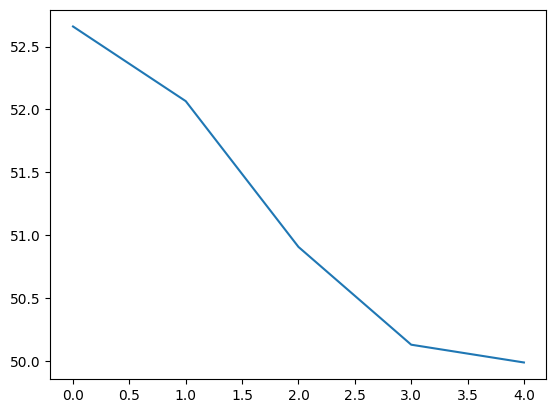

Starting epoch number 51


100%|██████████| 134/134 [00:04<00:00, 31.54it/s]


Loss for Training on Epoch 51 is 0.42278528213500977


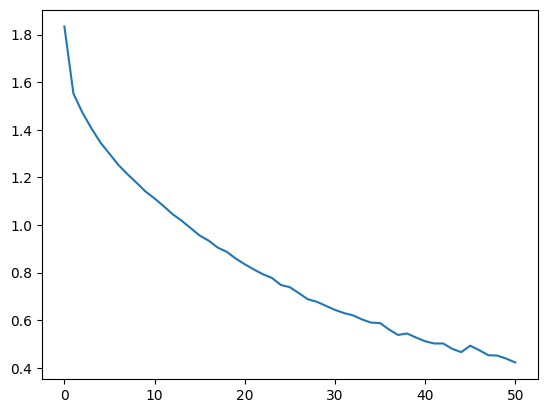

Starting epoch number 52


100%|██████████| 134/134 [00:04<00:00, 31.55it/s]


Loss for Training on Epoch 52 is 0.4182993173599243
Starting epoch number 53


100%|██████████| 134/134 [00:04<00:00, 31.45it/s]


Loss for Training on Epoch 53 is 0.4181520342826843
Starting epoch number 54


100%|██████████| 134/134 [00:04<00:00, 31.61it/s]


Loss for Training on Epoch 54 is 0.42609018087387085


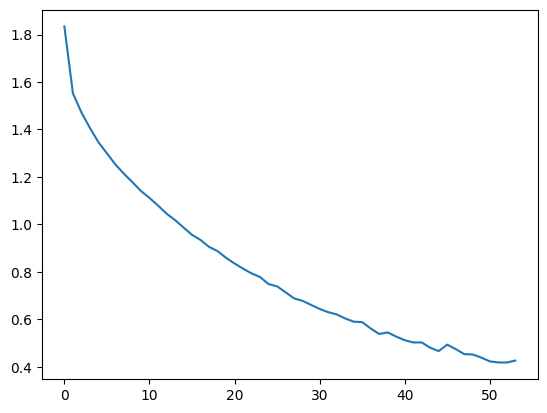

Starting epoch number 55


100%|██████████| 134/134 [00:04<00:00, 31.56it/s]


Loss for Training on Epoch 55 is 0.42652395367622375
Starting epoch number 56


100%|██████████| 134/134 [00:04<00:00, 31.45it/s]


Loss for Training on Epoch 56 is 0.40360987186431885
Starting epoch number 57


100%|██████████| 134/134 [00:04<00:00, 29.63it/s]


Loss for Training on Epoch 57 is 0.3917996883392334


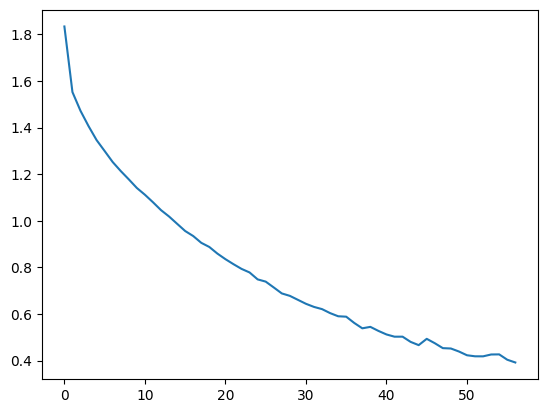

Starting epoch number 58


100%|██████████| 134/134 [00:04<00:00, 31.58it/s]


Loss for Training on Epoch 58 is 0.3824229836463928
Starting epoch number 59


100%|██████████| 134/134 [00:04<00:00, 31.43it/s]


Loss for Training on Epoch 59 is 0.3714176416397095
Starting epoch number 60


100%|██████████| 134/134 [00:04<00:00, 31.58it/s]


Loss for Training on Epoch 60 is 0.38327664136886597


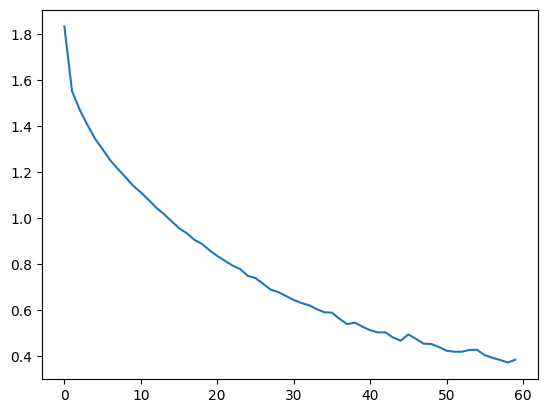

Accuracy of the network on the test images: 49 %
Accuarcy on validation set: 49.88678177186527


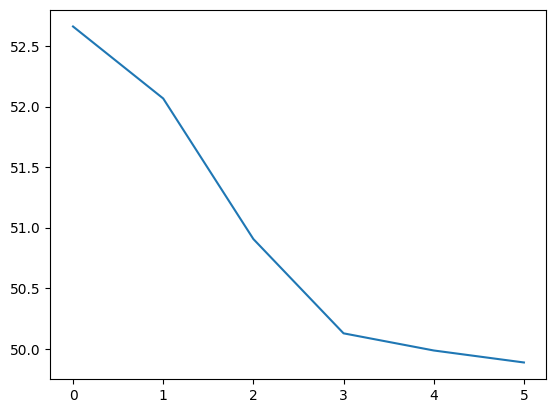

Starting epoch number 61


100%|██████████| 134/134 [00:04<00:00, 31.58it/s]


Loss for Training on Epoch 61 is 0.3697453737258911
Starting epoch number 62


100%|██████████| 134/134 [00:04<00:00, 31.36it/s]


Loss for Training on Epoch 62 is 0.3619651794433594
Starting epoch number 63


100%|██████████| 134/134 [00:04<00:00, 31.58it/s]


Loss for Training on Epoch 63 is 0.36749738454818726


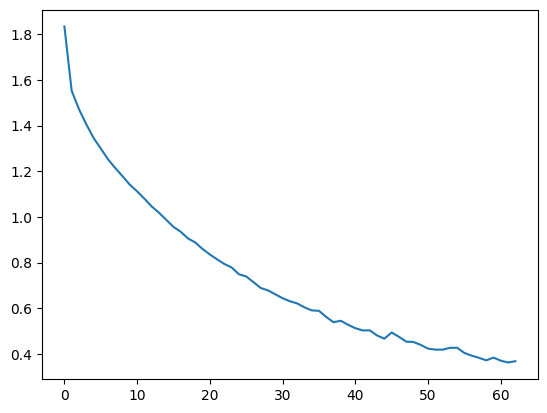

Starting epoch number 64


100%|██████████| 134/134 [00:04<00:00, 31.58it/s]


Loss for Training on Epoch 64 is 0.36163654923439026
Starting epoch number 65


100%|██████████| 134/134 [00:04<00:00, 31.41it/s]


Loss for Training on Epoch 65 is 0.340705543756485
Starting epoch number 66


100%|██████████| 134/134 [00:04<00:00, 31.56it/s]


Loss for Training on Epoch 66 is 0.34533628821372986


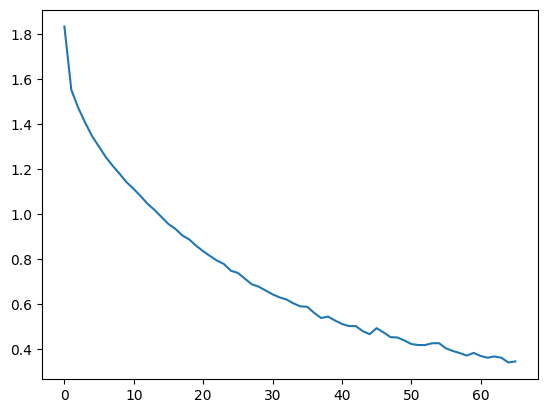

Starting epoch number 67


100%|██████████| 134/134 [00:04<00:00, 31.55it/s]


Loss for Training on Epoch 67 is 0.3731309175491333
Starting epoch number 68


100%|██████████| 134/134 [00:04<00:00, 31.45it/s]


Loss for Training on Epoch 68 is 0.3441713750362396
Starting epoch number 69


100%|██████████| 134/134 [00:04<00:00, 31.47it/s]


Loss for Training on Epoch 69 is 0.3317018449306488


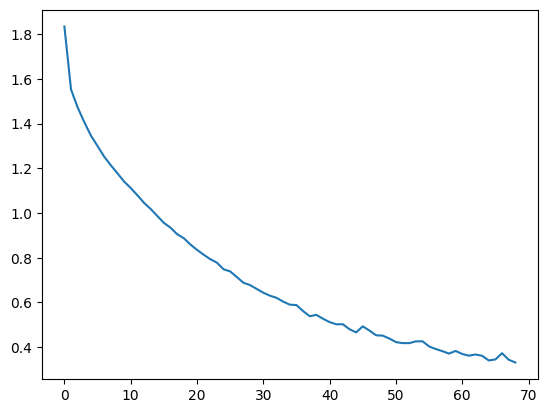

Starting epoch number 70


100%|██████████| 134/134 [00:04<00:00, 31.49it/s]


Loss for Training on Epoch 70 is 0.33734437823295593
Accuracy of the network on the test images: 48 %
Accuarcy on validation set: 48.48570619869799


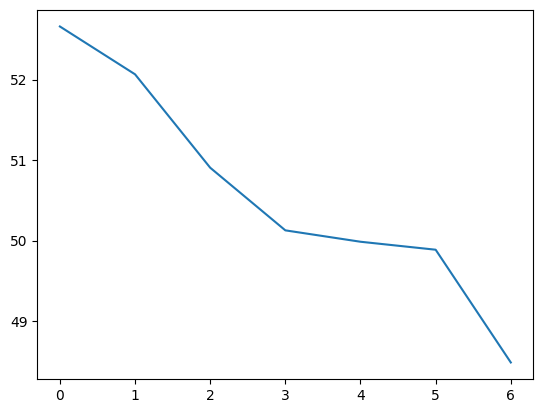

Starting epoch number 71


100%|██████████| 134/134 [00:04<00:00, 31.37it/s]


Loss for Training on Epoch 71 is 0.34712013602256775
Starting epoch number 72


100%|██████████| 134/134 [00:04<00:00, 31.56it/s]


Loss for Training on Epoch 72 is 0.3088916838169098


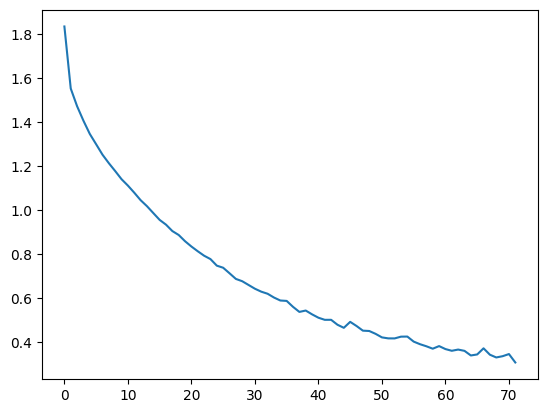

Starting epoch number 73


100%|██████████| 134/134 [00:04<00:00, 31.53it/s]


Loss for Training on Epoch 73 is 0.3110843896865845
Starting epoch number 74


100%|██████████| 134/134 [00:04<00:00, 31.43it/s]


Loss for Training on Epoch 74 is 0.3369966149330139
Starting epoch number 75


100%|██████████| 134/134 [00:04<00:00, 29.56it/s]


Loss for Training on Epoch 75 is 0.329750120639801


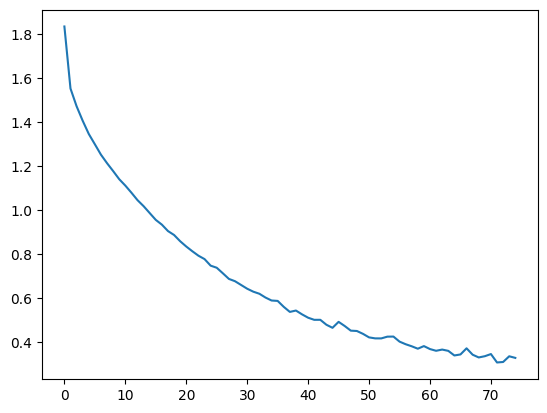

Starting epoch number 76


100%|██████████| 134/134 [00:04<00:00, 31.58it/s]


Loss for Training on Epoch 76 is 0.3363032042980194
Starting epoch number 77


100%|██████████| 134/134 [00:04<00:00, 31.45it/s]


Loss for Training on Epoch 77 is 0.3375636041164398
Starting epoch number 78


100%|██████████| 134/134 [00:04<00:00, 31.44it/s]


Loss for Training on Epoch 78 is 0.2824755609035492


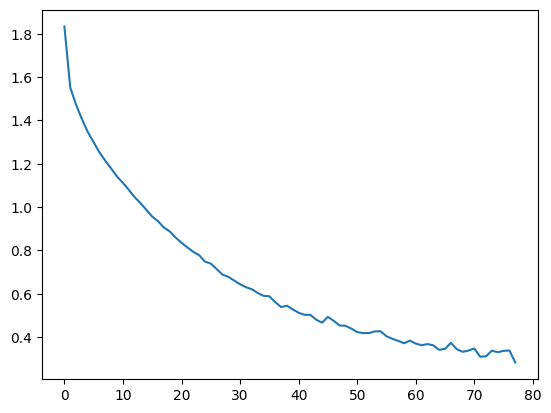

Starting epoch number 79


100%|██████████| 134/134 [00:04<00:00, 31.57it/s]


Loss for Training on Epoch 79 is 0.2725798189640045
Starting epoch number 80


100%|██████████| 134/134 [00:04<00:00, 31.48it/s]


Loss for Training on Epoch 80 is 0.2862531542778015
Accuracy of the network on the test images: 47 %
Accuarcy on validation set: 47.59411265213699


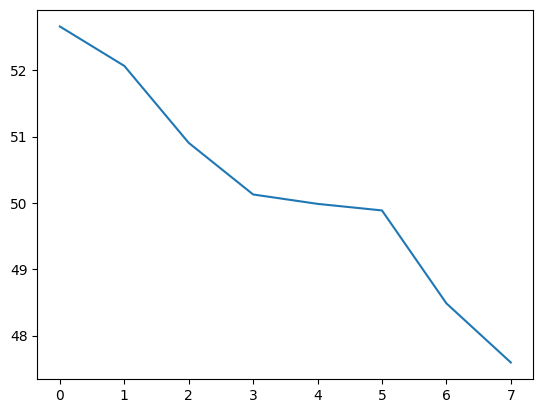

Starting epoch number 81


100%|██████████| 134/134 [00:04<00:00, 31.54it/s]


Loss for Training on Epoch 81 is 0.34180301427841187


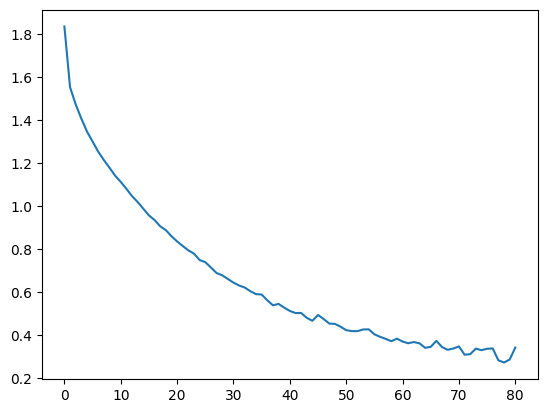

Starting epoch number 82


100%|██████████| 134/134 [00:04<00:00, 31.60it/s]


Loss for Training on Epoch 82 is 0.3028445243835449
Starting epoch number 83


100%|██████████| 134/134 [00:04<00:00, 31.41it/s]


Loss for Training on Epoch 83 is 0.30303266644477844
Starting epoch number 84


100%|██████████| 134/134 [00:04<00:00, 31.48it/s]


Loss for Training on Epoch 84 is 0.2951817214488983


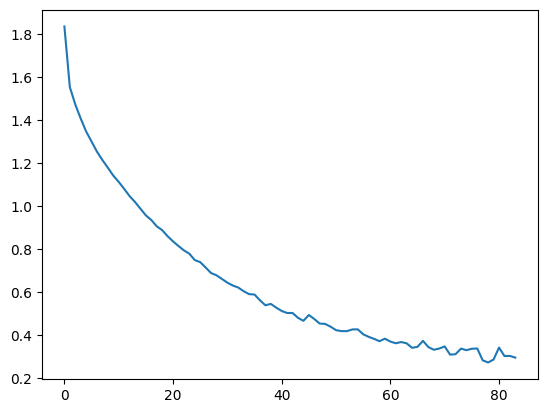

Starting epoch number 85


100%|██████████| 134/134 [00:04<00:00, 31.59it/s]


Loss for Training on Epoch 85 is 0.2936515212059021
Starting epoch number 86


100%|██████████| 134/134 [00:04<00:00, 31.52it/s]


Loss for Training on Epoch 86 is 0.2959337830543518
Starting epoch number 87


100%|██████████| 134/134 [00:04<00:00, 31.50it/s]


Loss for Training on Epoch 87 is 0.31669503450393677


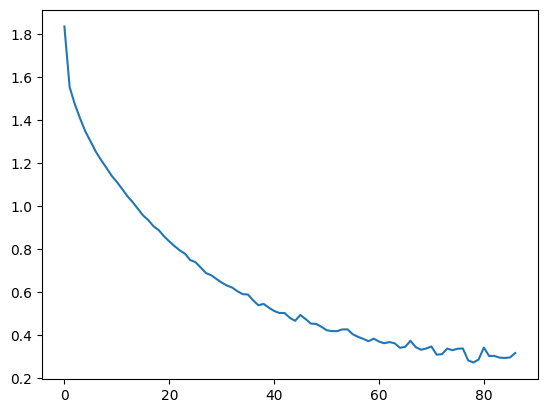

Starting epoch number 88


100%|██████████| 134/134 [00:04<00:00, 31.55it/s]


Loss for Training on Epoch 88 is 0.2658753991127014
Starting epoch number 89


100%|██████████| 134/134 [00:04<00:00, 31.55it/s]


Loss for Training on Epoch 89 is 0.24485018849372864
Starting epoch number 90


100%|██████████| 134/134 [00:04<00:00, 31.49it/s]


Loss for Training on Epoch 90 is 0.24578529596328735


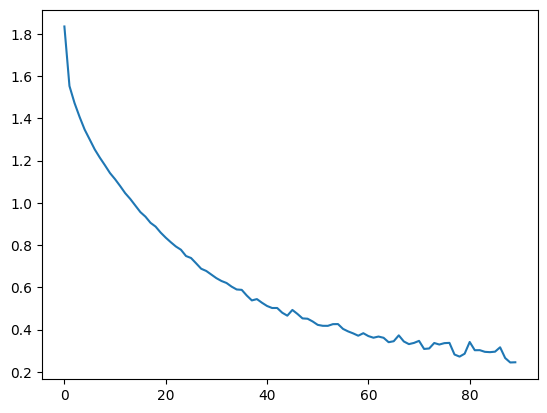

Accuracy of the network on the test images: 48 %
Accuarcy on validation set: 48.25926974242853


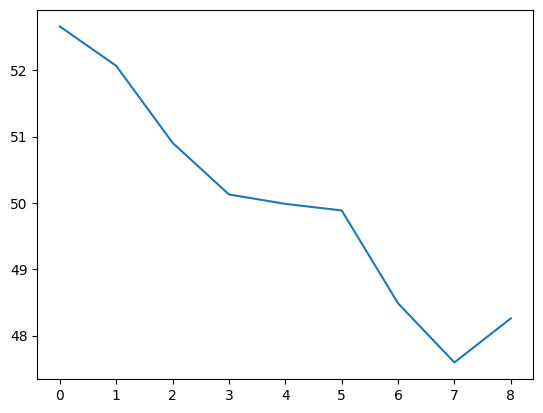

Starting epoch number 91


100%|██████████| 134/134 [00:04<00:00, 31.59it/s]


Loss for Training on Epoch 91 is 0.288344144821167
Starting epoch number 92


100%|██████████| 134/134 [00:04<00:00, 31.49it/s]


Loss for Training on Epoch 92 is 0.3432028591632843
Starting epoch number 93


100%|██████████| 134/134 [00:04<00:00, 28.79it/s]


Loss for Training on Epoch 93 is 0.2630794644355774


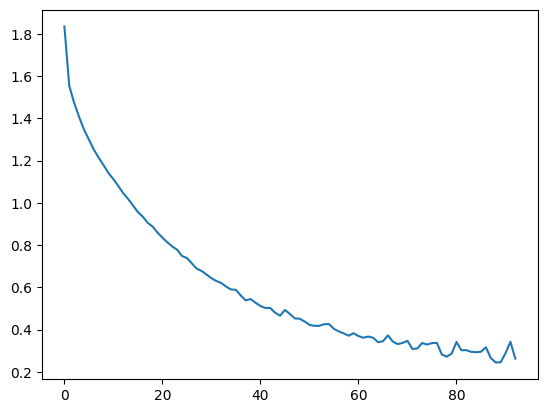

Starting epoch number 94


100%|██████████| 134/134 [00:04<00:00, 31.60it/s]


Loss for Training on Epoch 94 is 0.2749423384666443
Starting epoch number 95


100%|██████████| 134/134 [00:04<00:00, 31.56it/s]


Loss for Training on Epoch 95 is 0.24235300719738007
Starting epoch number 96


100%|██████████| 134/134 [00:04<00:00, 31.40it/s]


Loss for Training on Epoch 96 is 0.2343262881040573


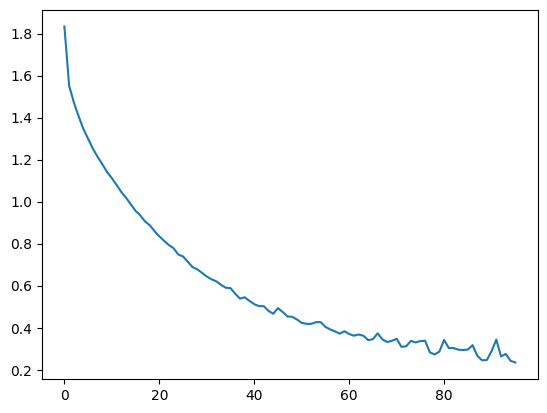

Starting epoch number 97


100%|██████████| 134/134 [00:04<00:00, 31.56it/s]


Loss for Training on Epoch 97 is 0.23323583602905273
Starting epoch number 98


100%|██████████| 134/134 [00:04<00:00, 31.58it/s]


Loss for Training on Epoch 98 is 0.26186907291412354
Starting epoch number 99


100%|██████████| 134/134 [00:04<00:00, 31.42it/s]


Loss for Training on Epoch 99 is 0.29404357075691223


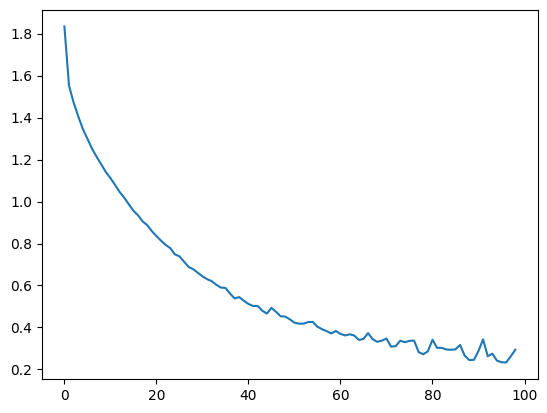

Do you want to continue training?[yes]no


In [ ]:
# Training the Classifier
NUM_EPOCHS = 350
TEST_FREQUENCY = 10
LOSS_PLOT_FREQUENCY = 3


# for epoch in range(1, NUM_EPOCHS+1):
epoch = 1
saveptr = 0

acc_arr = []
loss_arr = []

while True:
    if epoch > 99 and epoch % 100 == 0:
      res = input("Do you want to continue training?[yes]")
      if res.lower() != 'yes':
        break
    if epoch > 99 and epoch % 100 == 0:
      res = input("Do you want to save weights?[yes]")
      if res.lower() == 'yes':
        torch.save(classifier.state_dict(), f'/content/drive/MyDrive/classifierV2_{saveptr}.pt')
        saveptr += 1


    print("Starting epoch number " + str(epoch))
    train_loss = train_classifier(train_loader, classifier, criterion, optimizer)
    loss_arr.append(train_loss)
    print("Loss for Training on Epoch " +str(epoch) + " is "+ str(train_loss))
    if(epoch % LOSS_PLOT_FREQUENCY == 0):
      plt.plot([i for i in range(len(loss_arr))], loss_arr)
      plt.show()

    if(epoch%TEST_FREQUENCY==0):
        acc = test_classifier(val_loader, classifier)
        acc_arr.append(acc)
        print(f'Accuarcy on validation set: {acc}')
        plt.plot([i for i in range(len(acc_arr))], acc_arr)
        plt.show()
    epoch += 1


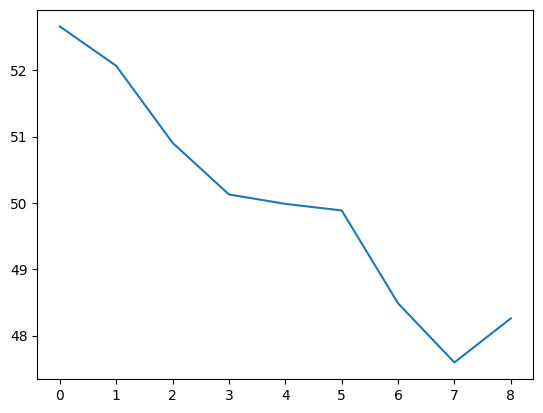

In [ ]:
plt.plot([i for i in range(len(acc_arr))], acc_arr)
plt.show()

neutral


array([[117, 119, 115, ...,  93,  94,  92],
       [121, 118, 120, ...,  99,  97,  93],
       [124, 120, 123, ..., 103,  98, 103],
       ...,
       [181, 179, 182, ..., 176, 172, 168],
       [180, 182, 180, ..., 177, 173, 168],
       [183, 183, 180, ..., 177, 172, 167]], dtype=uint8)
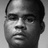

In [ ]:
print(mapper[val_lab[48]])
val_img[48]

In [ ]:
def testSingle(testNum, data, data_lab):
  t = (torch.FloatTensor(data[testNum]))
  t = t.view((1, 48, 48))
  t = torch.FloatTensor(t)
  device = classifier.conv1.weight.device
  t = t.to(device)
  testEmo = torch.argmax(classifier.forward(t))
  testEmo = testEmo.detach().cpu().numpy().tolist()
  # print(testEmo, testEmo.shape())
  # print("Predicted: ", mapper[testEmo])
  # print("OG: ", mapper[val_lab[testNum]])
  # val_img[testNum]
  # print(1 if mapper[testEmo] == mapper[val_lab[testNum]] else 0)
  return 1 if mapper[testEmo] == mapper[data_lab[testNum]] else 0

In [ ]:
# Validation set
correct = total = 0
for i in tqdm(range(val_img.shape[0])):
  correct += testSingle(i, val_img, val_lab)
  total += 1
(correct / total) * 100

100%|██████████| 7066/7066 [00:05<00:00, 1281.22it/s]


49.235776960090575

In [ ]:
# Test set
correct = total = 0
for i in tqdm(range(X_test.shape[0])):
  correct += testSingle(i, X_test, y_test)
  total += 1
(correct / total) * 100

100%|██████████| 5765/5765 [00:04<00:00, 1185.92it/s]


48.10060711188205

In [ ]:
# Train set
correct = total = 0
for i in tqdm(range(tr_img.shape[0])):
  correct += testSingle(i, tr_img, tr_lab)
  total += 1
(correct / total) * 100

100%|██████████| 34121/34121 [00:27<00:00, 1254.48it/s]


91.48325078397468

In [ ]:
torch.save(classifier.state_dict(), '/content/drive/MyDrive/classifierFinal.pt')


In [ ]:
# classifier = Classifier(NUM_CLASSES).to(device)
# classifier.load_state_dict(torch.load('/content/drive/MyDrive/classifierFinal.pt', map_location= torch.device('cpu')))
# classifier.eval()


Classifier(
  (conv1): Conv2d(1, 128, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=16, out_features=7, bias=True)
  (fc2): Linear(in_features=12, out_features=7, bias=True)
)

In [ ]:
faceDetector = FaceDetector()

In [ ]:
def findEmotion(img):
  t = (torch.FloatTensor(img))
  t = t.view((1, 48, 48))
  t = torch.FloatTensor(t)
  device = classifier.conv1.weight.device
  t = t.to(device)
  testEmo = torch.argmax(classifier.forward(t))
  testEmo = testEmo.detach().cpu().numpy().tolist()
  print("Predicted : ", mapper[testEmo])
  return mapper[testEmo]

<IPython.core.display.Javascript object>

Saved to photo.jpg
Predicted :  happy


'happy'

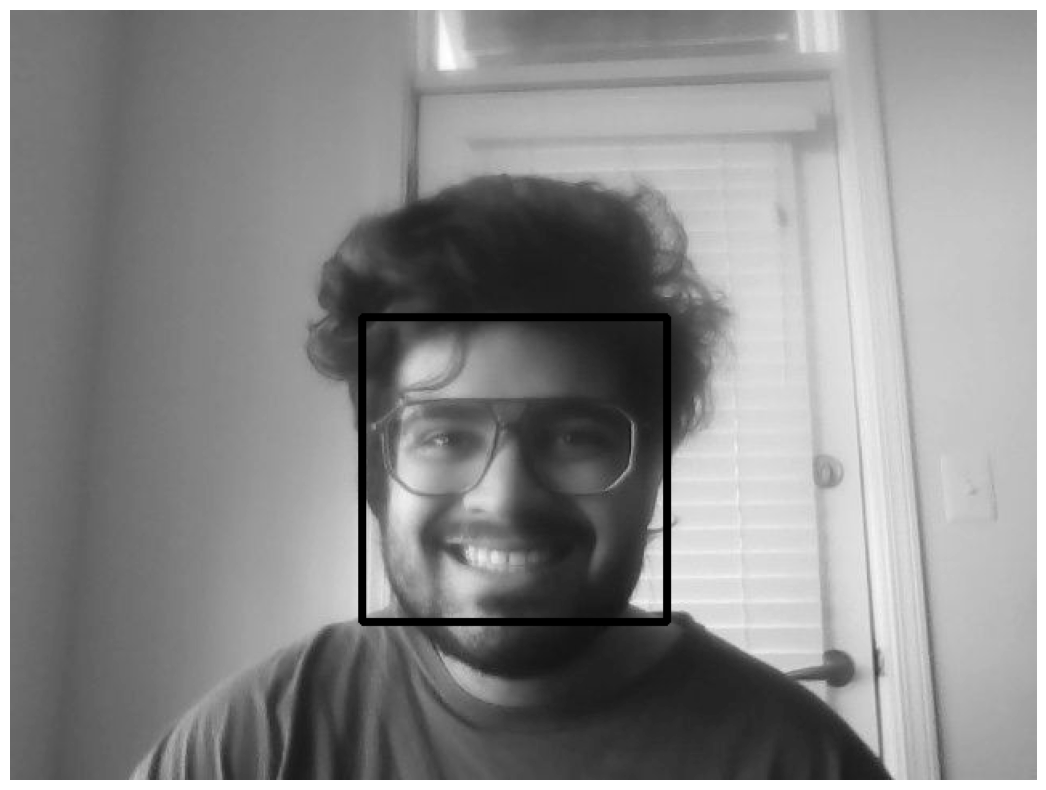

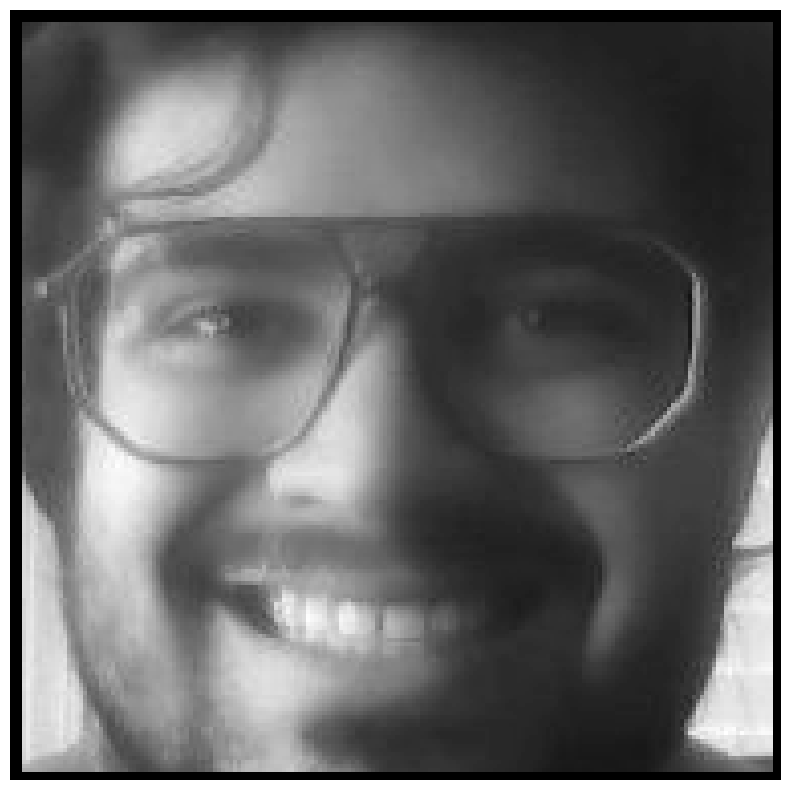

In [ ]:
tempImg = faceDetector.run()
tempImg = cv2.resize(tempImg, (48, 48))
findEmotion(tempImg)

<IPython.core.display.Javascript object>

Saved to photo.jpg
Predicted :  neutral


'neutral'

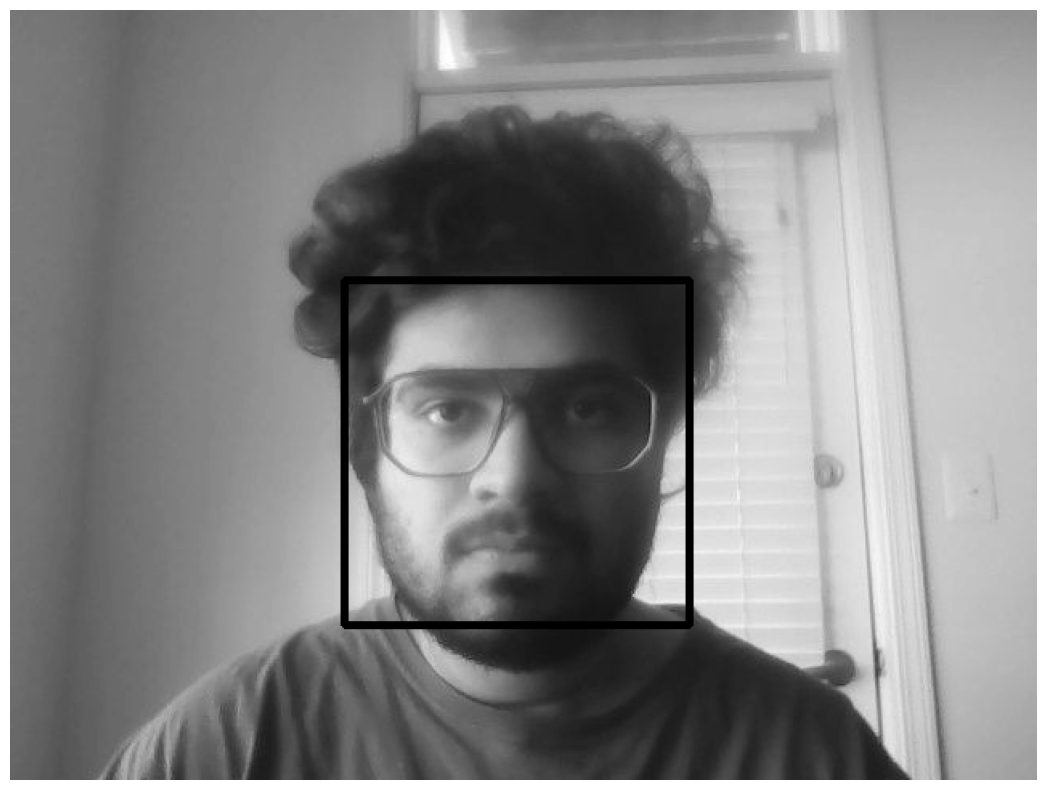

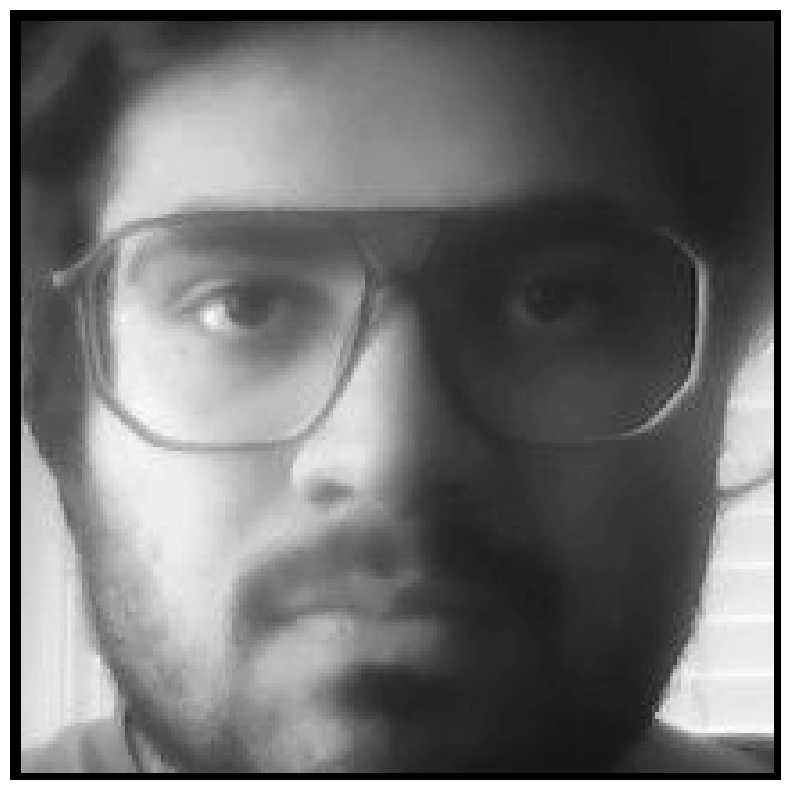

In [ ]:
tempImg = faceDetector.run()
tempImg = cv2.resize(tempImg, (48, 48))
findEmotion(tempImg)

<IPython.core.display.Javascript object>

Saved to photo.jpg
Predicted :  sad


'sad'

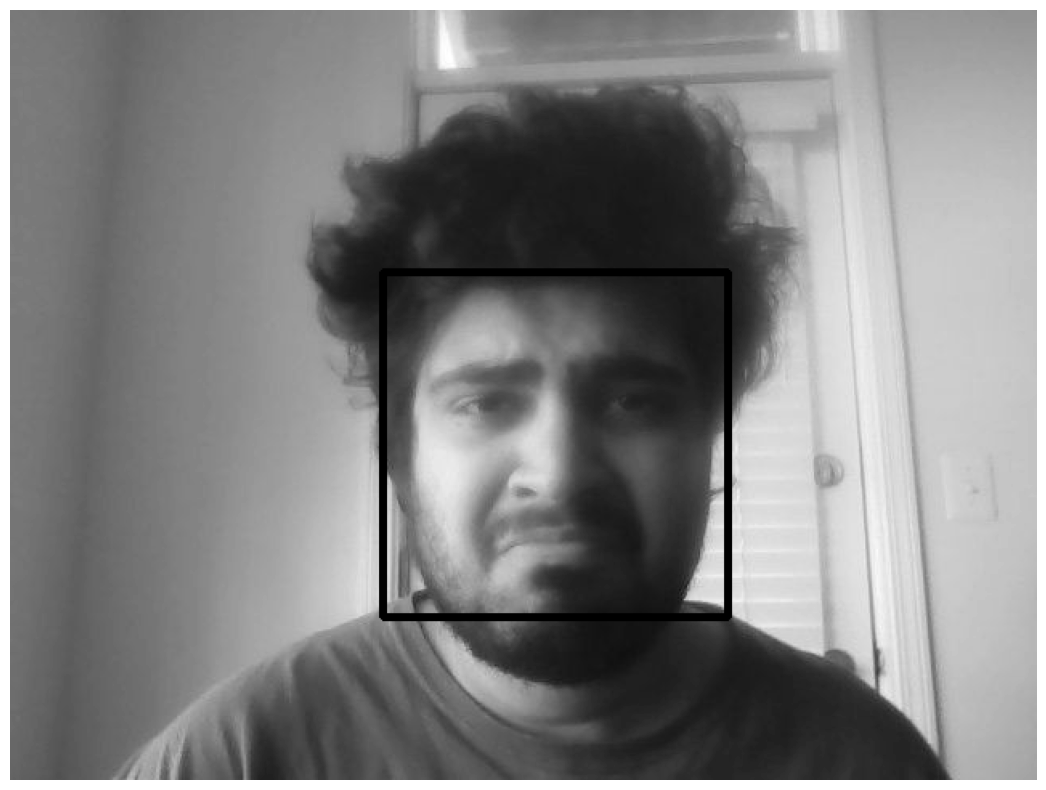

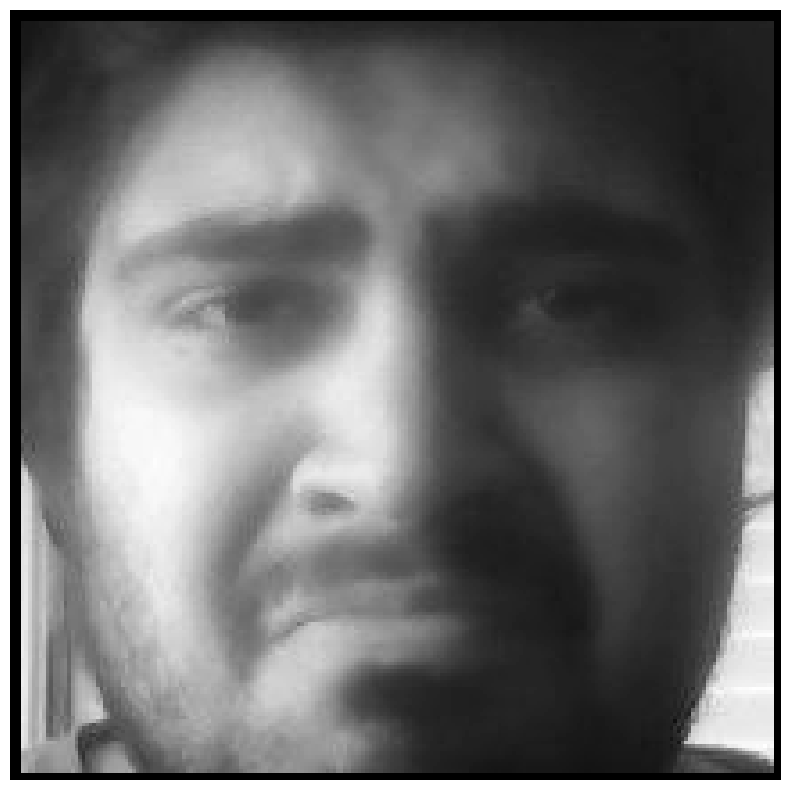

In [ ]:
tempImg = faceDetector.run()
tempImg = cv2.resize(tempImg, (48, 48))
findEmotion(tempImg)

<IPython.core.display.Javascript object>

Saved to photo.jpg
Predicted :  angry


'angry'

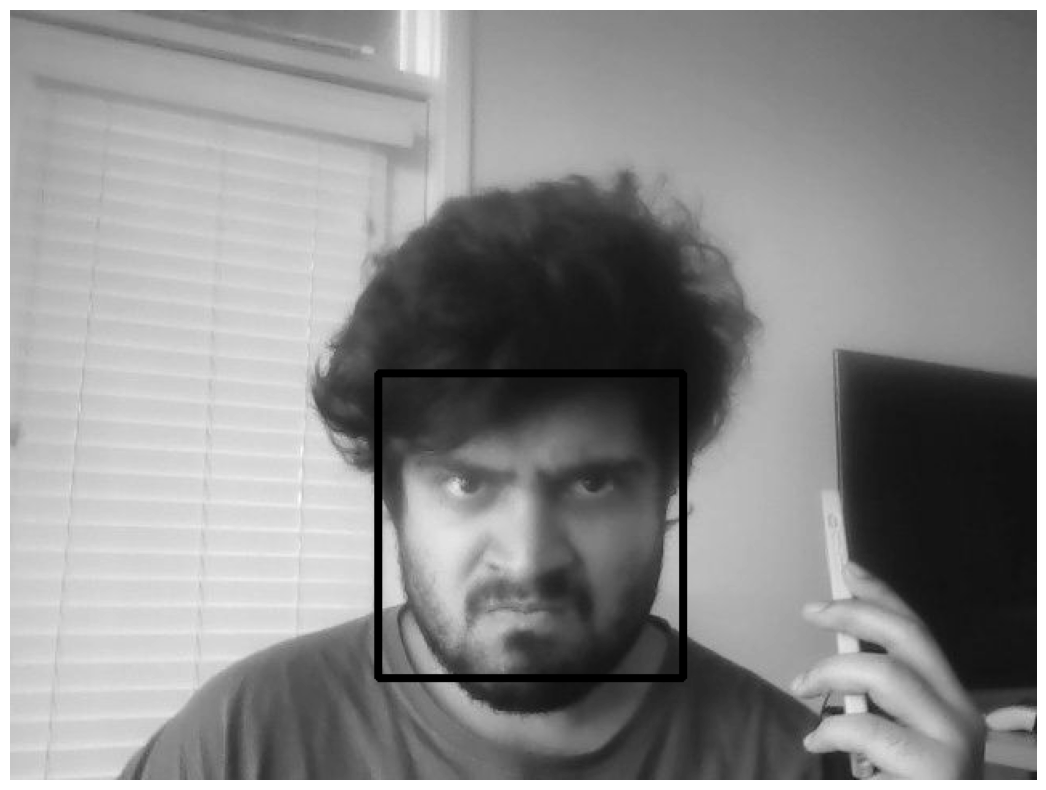

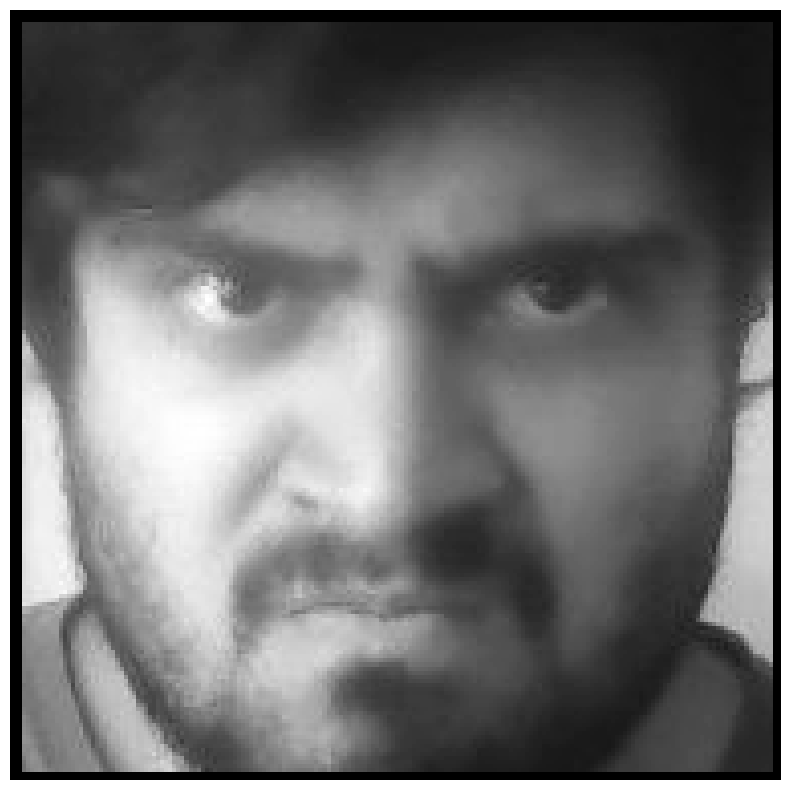

In [ ]:
tempImg = faceDetector.run()
tempImg = cv2.resize(tempImg, (48, 48))
findEmotion(tempImg)

<IPython.core.display.Javascript object>

Saved to photo.jpg
Predicted :  surprise


'surprise'

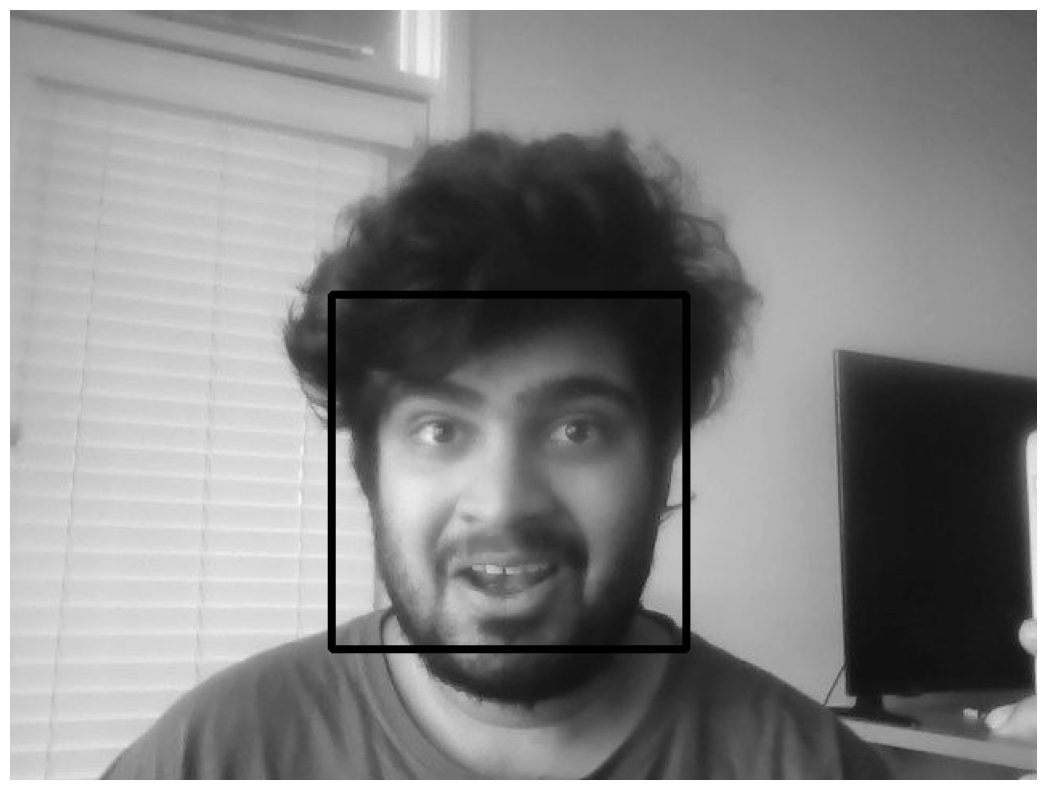

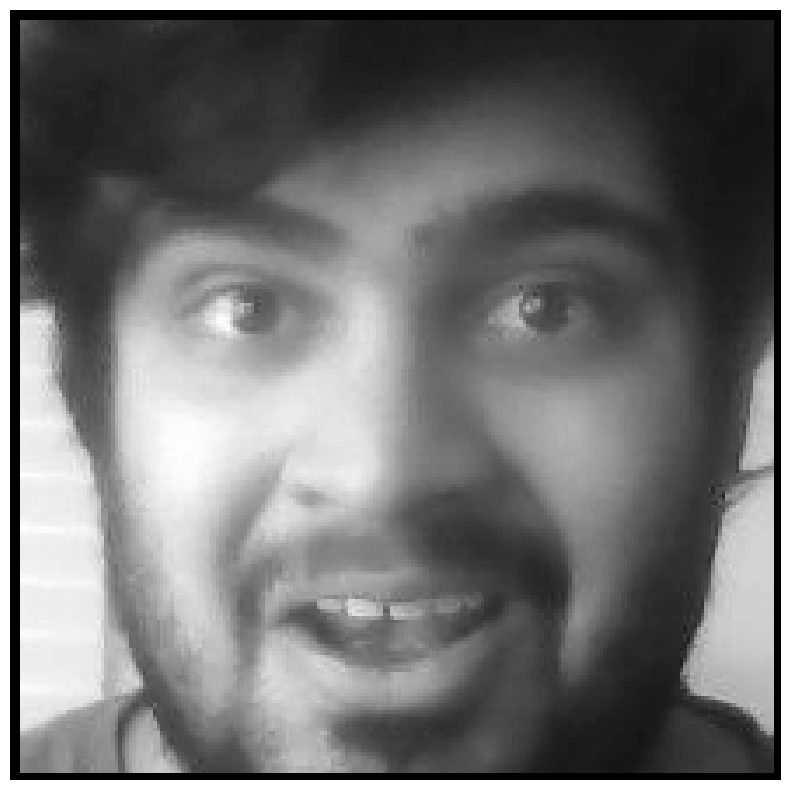

In [ ]:
tempImg = faceDetector.run()
tempImg = cv2.resize(tempImg, (48, 48))
findEmotion(tempImg)

<IPython.core.display.Javascript object>

Saved to photo.jpg
Predicted :  happy


'happy'

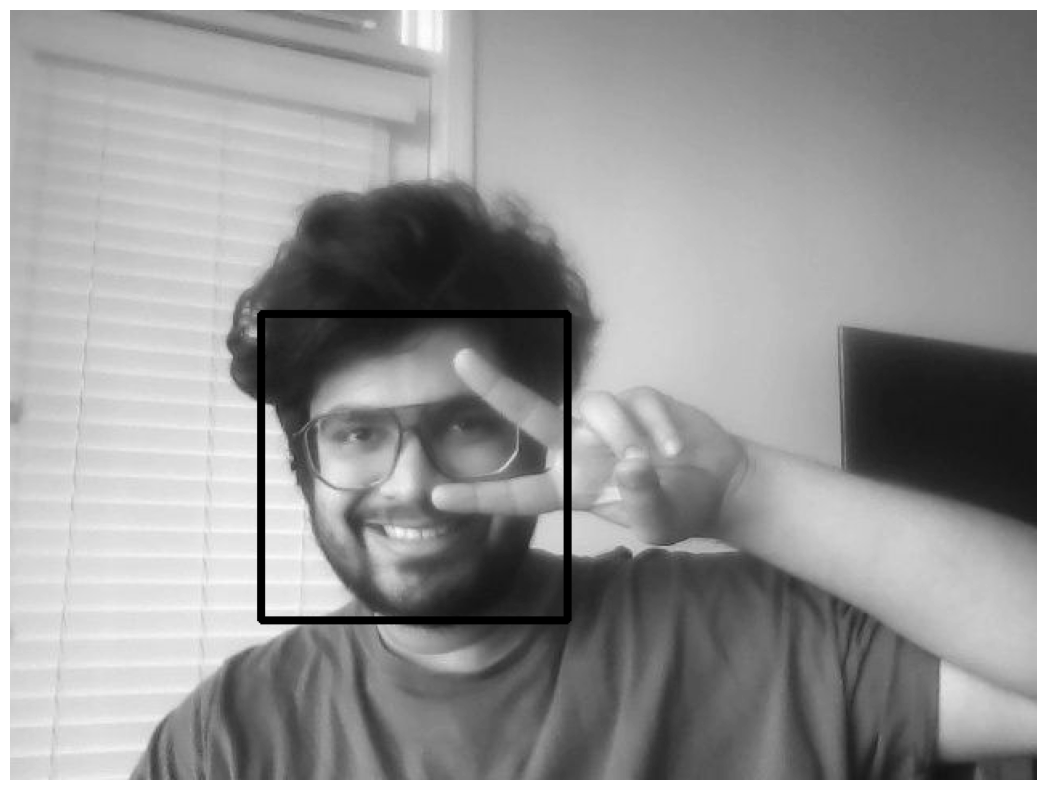

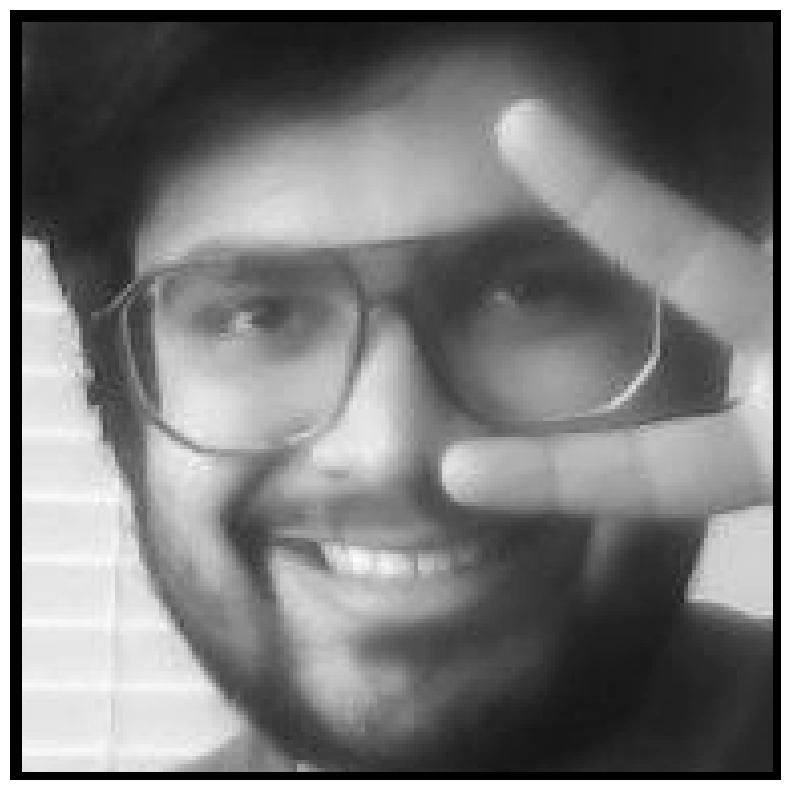

In [ ]:
tempImg = faceDetector.run()
tempImg = cv2.resize(tempImg, (48, 48))
findEmotion(tempImg)

<IPython.core.display.Javascript object>

Saved to photo.jpg
1 [[319  70 140 140]]
Predicted :  disgust


'disgust'

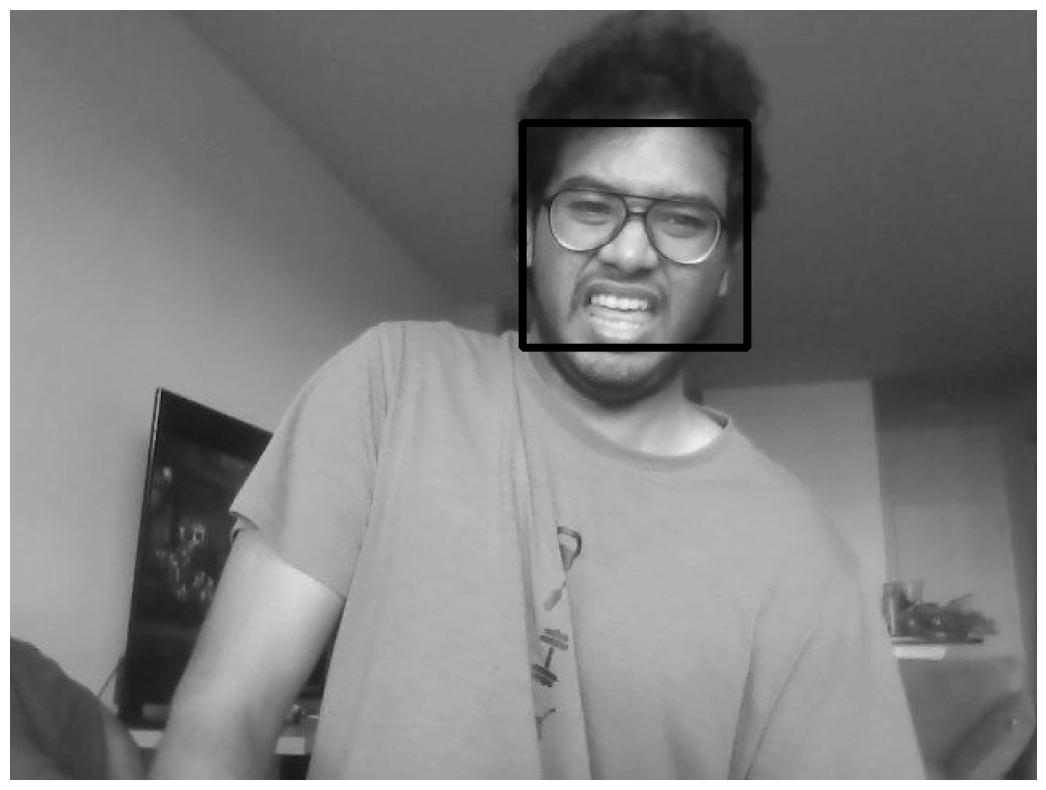

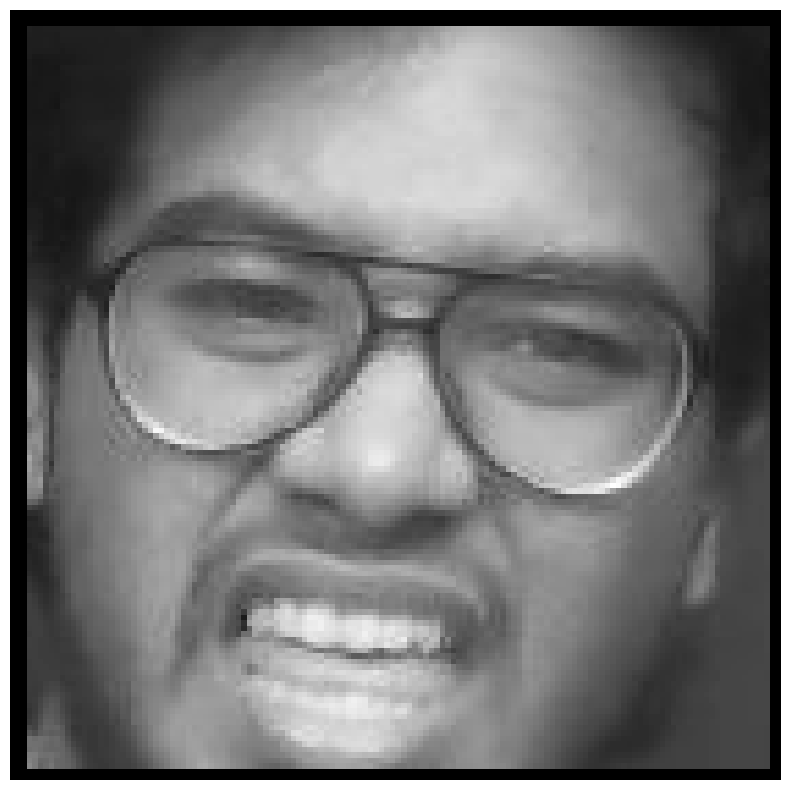

In [ ]:
tempImg = faceDetector.run()
tempImg = cv2.resize(tempImg, (48, 48))
findEmotion(tempImg)

In [ ]:
mapper

{0: 'angry',
 1: 'disgust',
 2: 'fear',
 3: 'happy',
 4: 'neutral',
 5: 'sad',
 6: 'surprise'}

<IPython.core.display.Javascript object>

Saved to photo.jpg
1 [[445 203 126 126]]
Predicted :  fear


'fear'

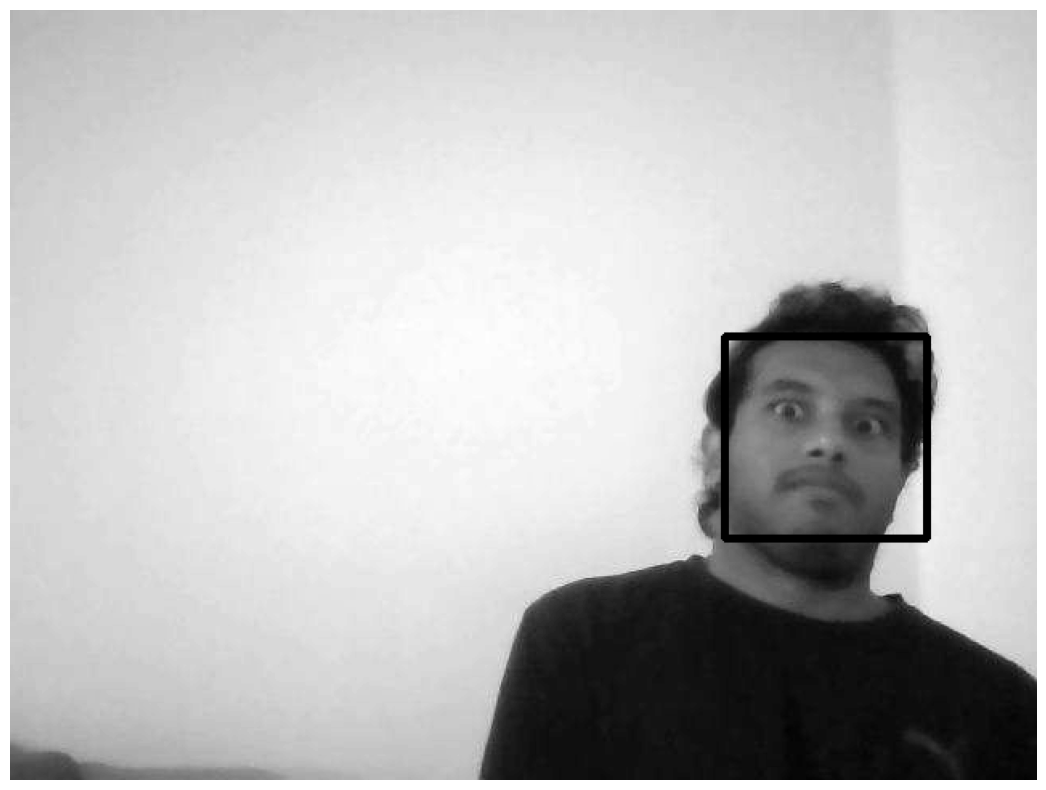

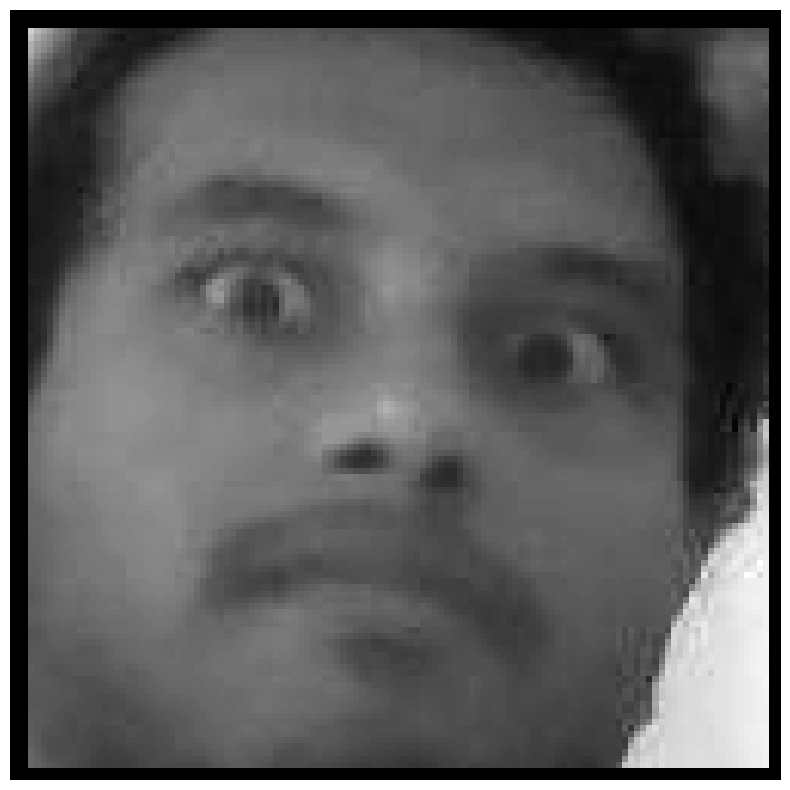

In [ ]:
tempImg = faceDetector.run()
tempImg = cv2.resize(tempImg, (48, 48))
findEmotion(tempImg)

<IPython.core.display.Javascript object>

Saved to photo.jpg
1 [[301 183 205 205]]
Predicted :  happy


'happy'

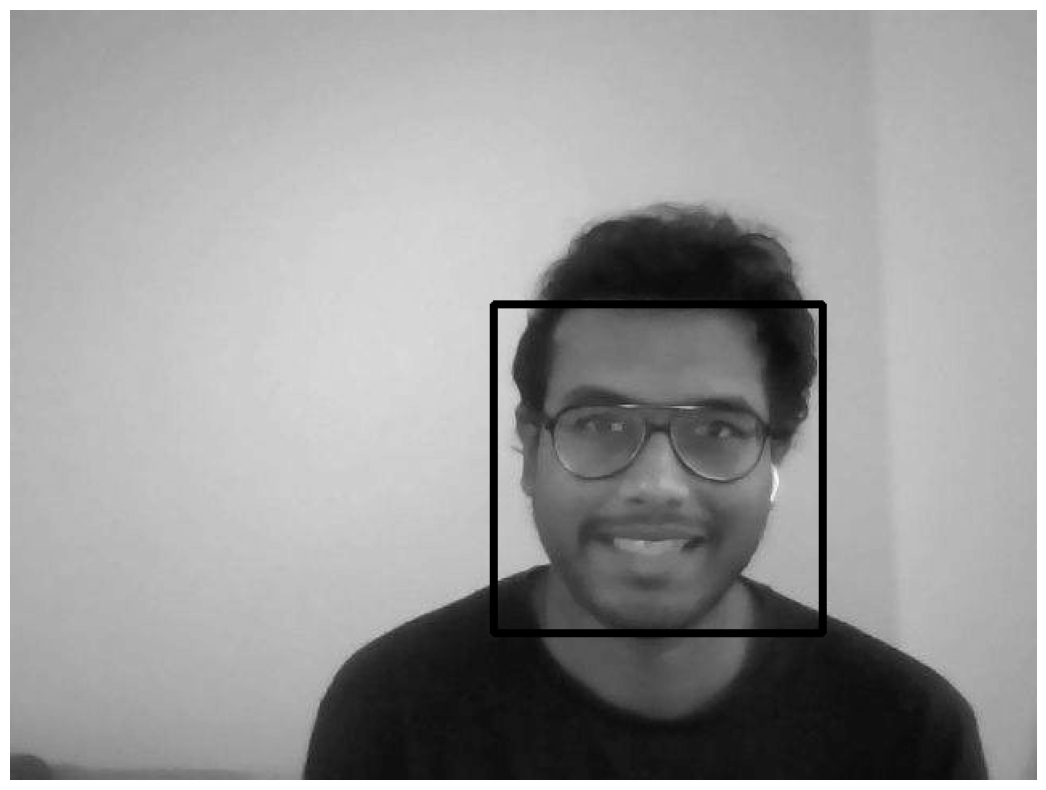

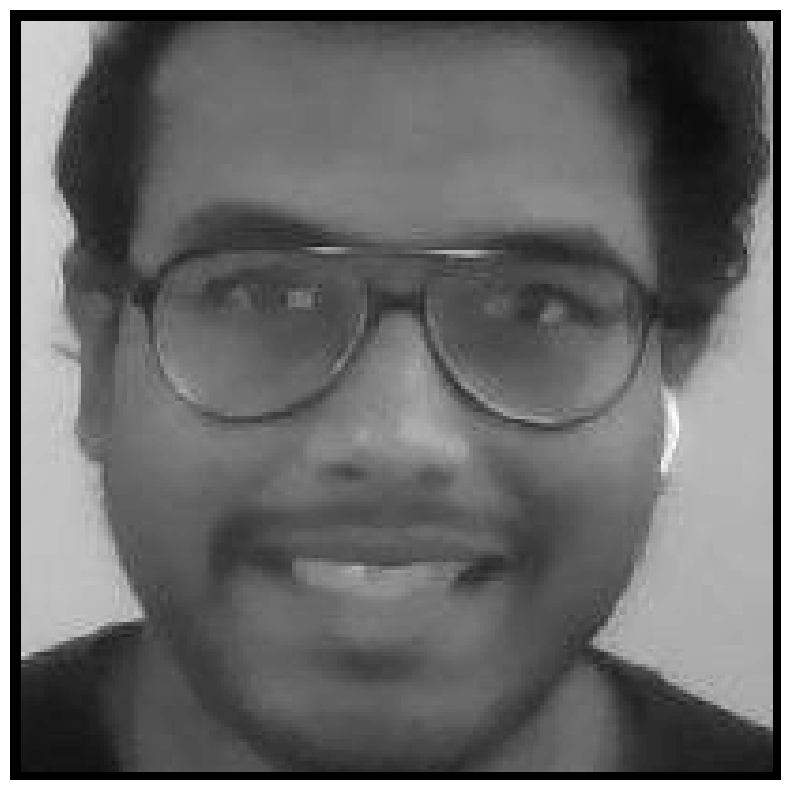

In [ ]:
tempImg = faceDetector.run()
tempImg = cv2.resize(tempImg, (48, 48))
findEmotion(tempImg)

<IPython.core.display.Javascript object>

Saved to photo.jpg
1 [[313 186 157 157]]
Predicted :  sad


'sad'

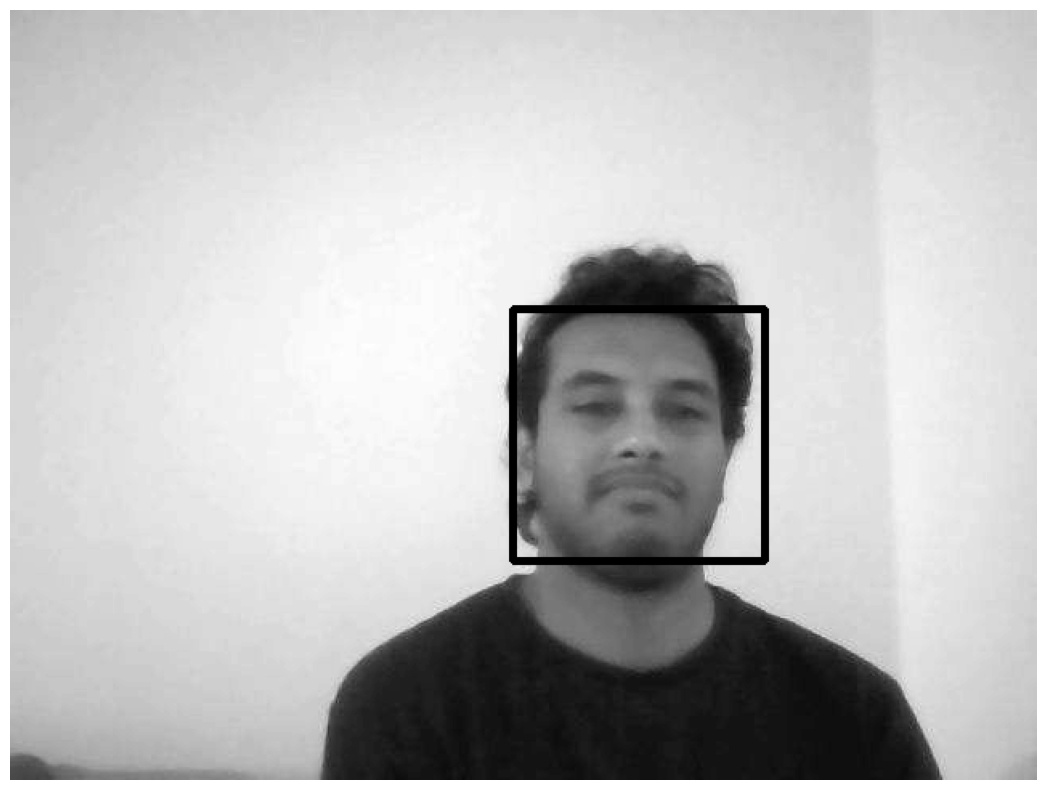

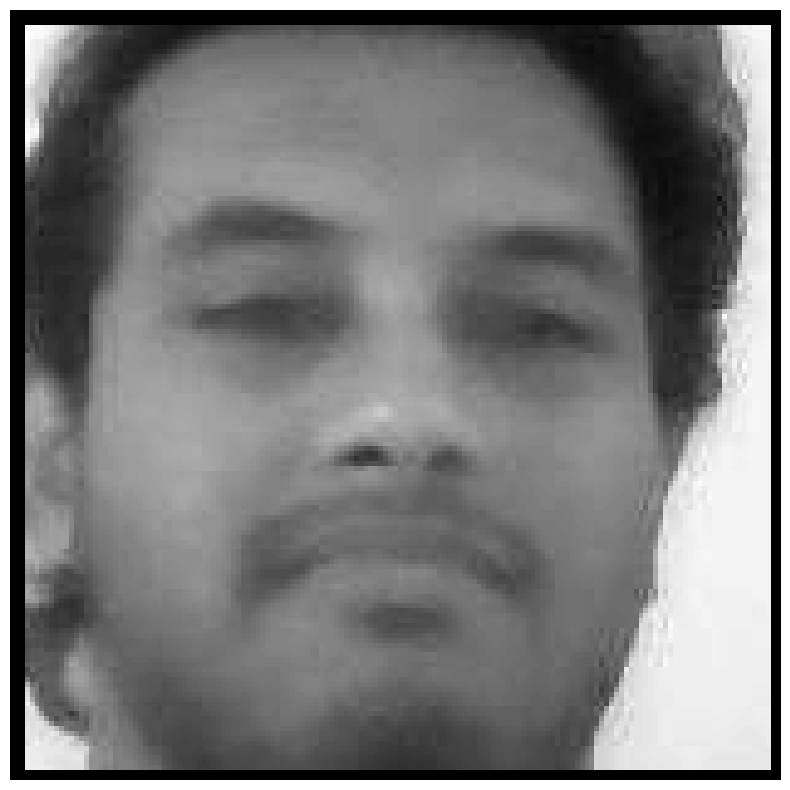

In [ ]:
tempImg = faceDetector.run()
tempImg = cv2.resize(tempImg, (48, 48))
findEmotion(tempImg)

<IPython.core.display.Javascript object>

Saved to photo.jpg
1 [[293 159 192 192]]
Predicted :  neutral


'neutral'

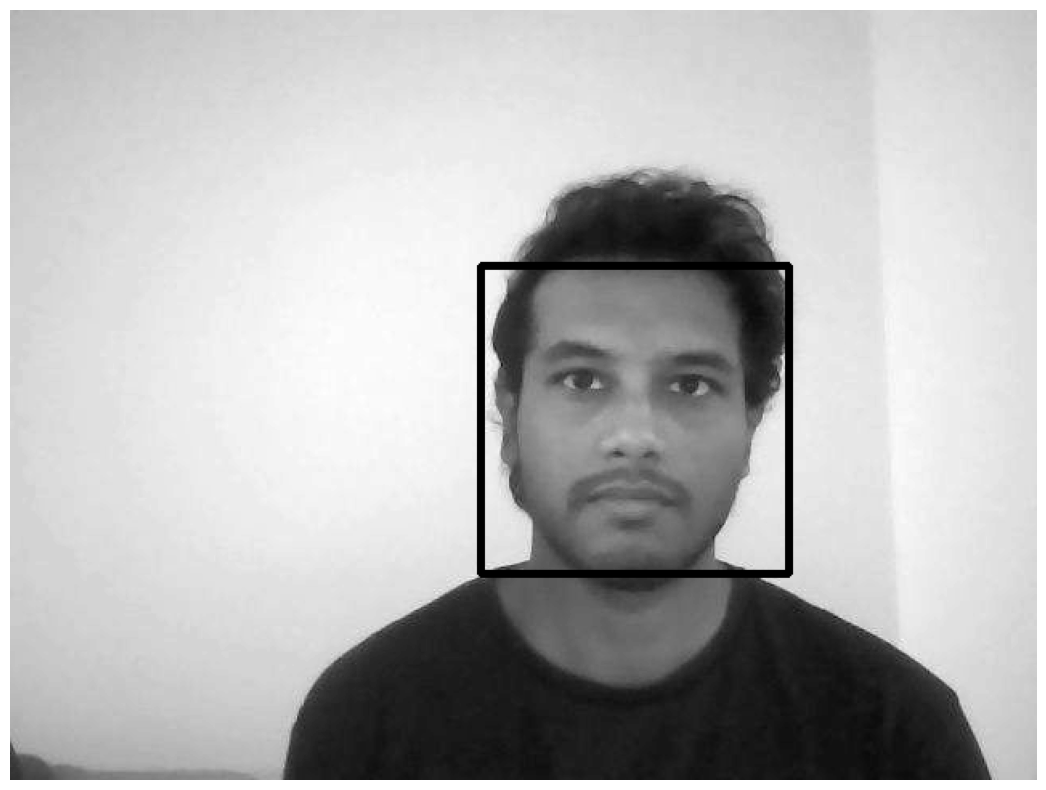

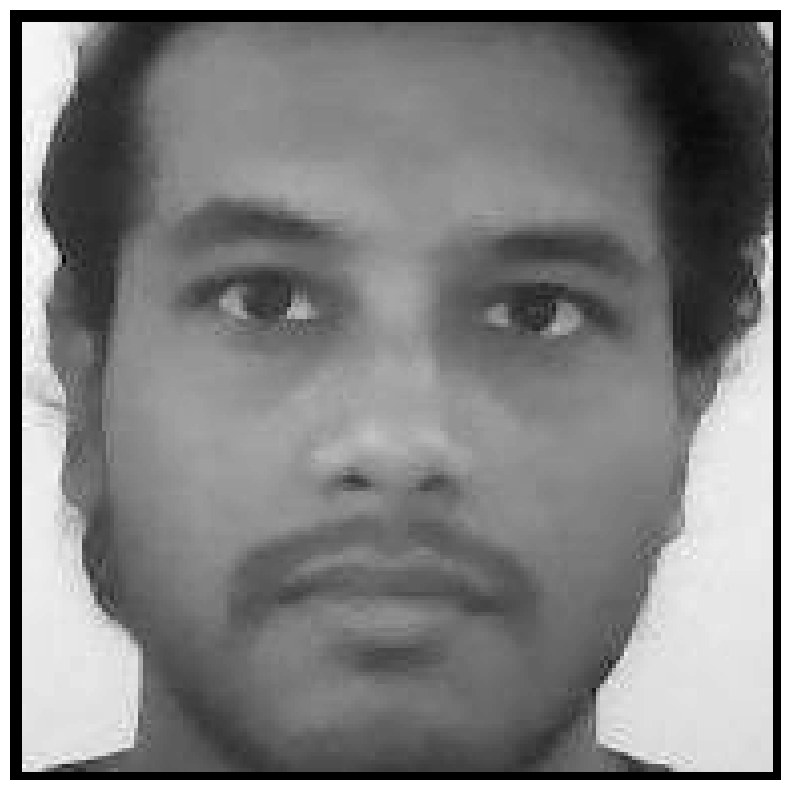

In [ ]:
tempImg = faceDetector.run()
tempImg = cv2.resize(tempImg, (48, 48))
findEmotion(tempImg)

<IPython.core.display.Javascript object>

Saved to photo.jpg
1 [[302 184 151 151]]
Predicted :  surprise


'surprise'

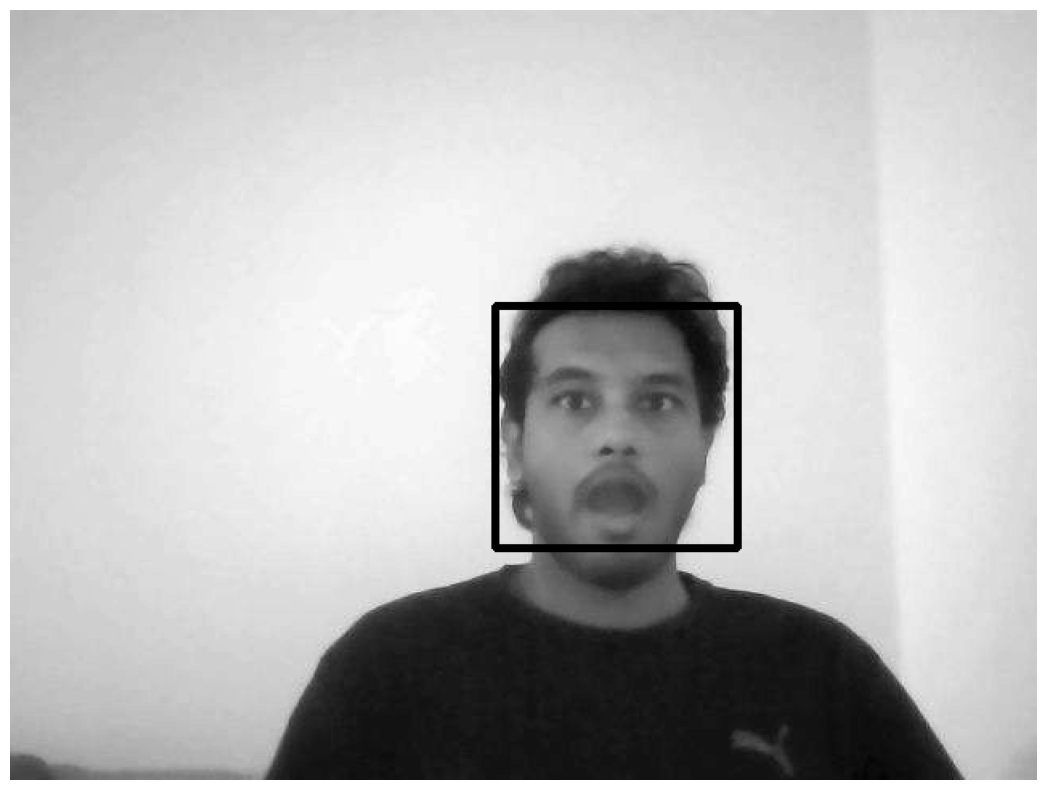

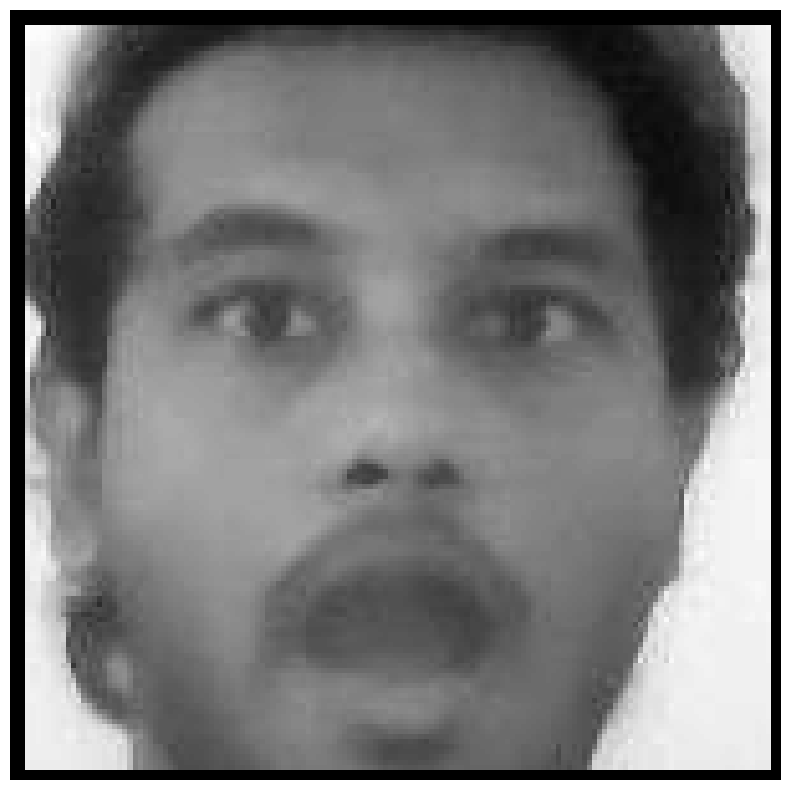

In [ ]:
tempImg = faceDetector.run()
tempImg = cv2.resize(tempImg, (48, 48))
findEmotion(tempImg)

<IPython.core.display.Javascript object>

Saved to photo.jpg
1 [[332 116 292 292]]
Predicted :  angry


'angry'

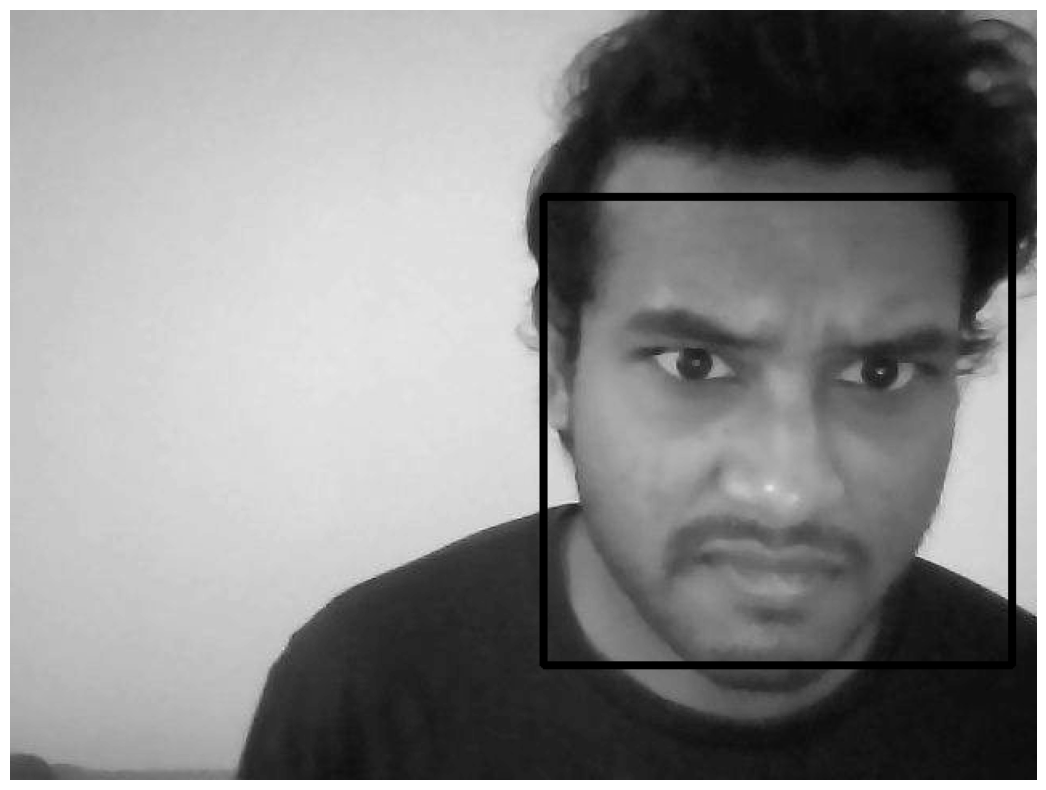

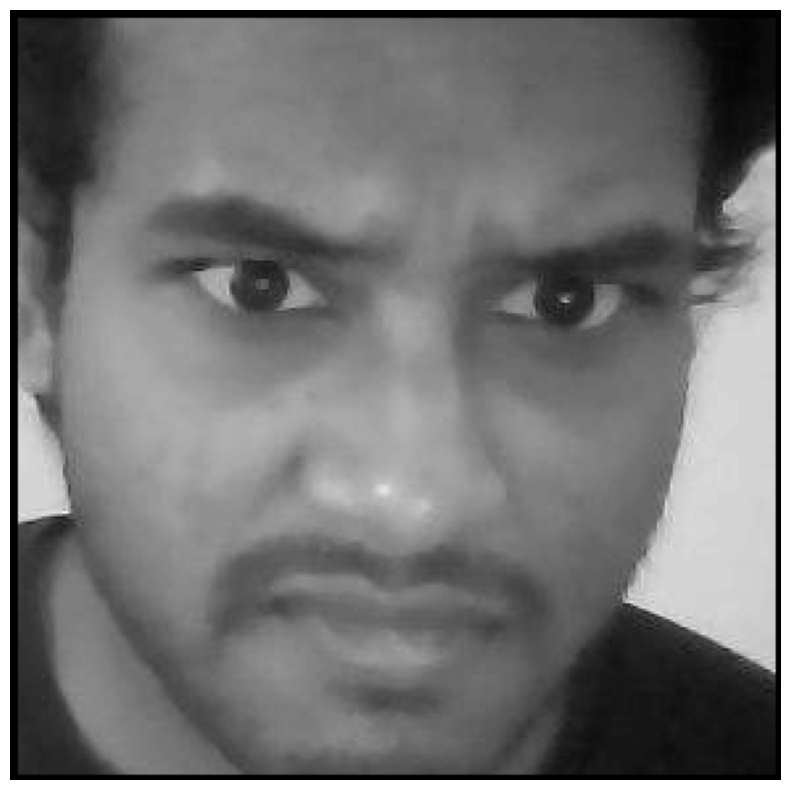

In [ ]:
tempImg = faceDetector.run()
tempImg = cv2.resize(tempImg, (48, 48))
findEmotion(tempImg)